# COMP90084 Assignment 1 Part 2-3

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import partial_trace, DensityMatrix, Statevector, state_fidelity
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import MCMT

import numpy as np
from numpy.linalg import eig
import scipy.linalg as la 
import matplotlib.pyplot as plt
import random
from sklearn import datasets

%matplotlib inline
# shots simulation
backend_sim = Aer.get_backend('qasm_simulator')
# statevector
backend_sv = Aer.get_backend('statevector_simulator')

## Question 1

### Question 1.1

In [2]:
# refer to COMP90084 Week 5 Tutorial

T = np.array([[1,0],[0,np.exp(1j/4*np.pi)]])

def teleportation_circ(alpha, beta):
    # normalize the amplitude
    norm_factor = np.sqrt(np.real(alpha*np.conjugate(alpha))+np.real(beta*np.conjugate(beta)))
    alpha = alpha/norm_factor
    beta = beta/norm_factor
    psi = DensityMatrix(Statevector([alpha, beta]))
    T_psi = DensityMatrix(np.matmul(T, Statevector([alpha, beta])))
    print("State to be teleported: \n|psi> = ({}) * |0> + ({}) * |1>\n".format(alpha, beta),np.real_if_close(psi.data))
    print("\n which T|psi> =\n", np.real_if_close(T_psi.data))
    alice = QuantumRegister(1, "alice")
    bob = QuantumRegister(1, "bob")
    z_classical = ClassicalRegister(1, "z")
    qc = QuantumCircuit(alice, bob, z_classical)
    qc.initialize([alpha, beta], alice) 
    qc.barrier()
    qc.cx(alice, bob[0])
    qc.tdg(alice)
    qc.h(alice)
    qc.s(bob[0])
    qc.barrier()
    qc.measure(alice, z_classical)
    qc.barrier()
    qc.z(bob[0]).c_if(z_classical, 1)
    # qc.tdg(bob[0]) # to verify
    
    # take a snap shot of the final state
    qc.snapshot(label="Bob_State", qubits=[bob[0]])
    qc.draw('mpl',style="bw", scale = 1)
    return qc

State to be teleported: 
|psi> = (-0.7071067811865476) * |0> + (0.7071067811865476j) * |1>
 [[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]

 which T|psi> =
 [[0.5       +0.j         0.35355339+0.35355339j]
 [0.35355339-0.35355339j 0.5       +0.j        ]]

Classical information sent by Alice: dict_keys(['1'])

State recieved by Bob:
 [[0.5       +0.j         0.35355339+0.35355339j]
 [0.35355339-0.35355339j 0.5       +0.j        ]]


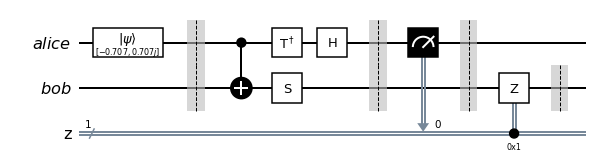

In [3]:
# change the state to be teleported
psi = [-1/np.sqrt(2), 1j/np.sqrt(2)]
# psi = [1/np.sqrt(2), 1/np.sqrt(2)]
# psi = [-1/np.sqrt(2)+1j/2, 1j/2]
# psi = [0,1]

qc=teleportation_circ(*psi)
job = backend_sv.run(transpile(qc, backend_sv), shots=1)
result = job.result()
counts = result.get_counts(qc)
print("\nClassical information sent by Alice:", counts.keys())
bob_state = partial_trace(result.get_statevector(), [0]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
print("\nState recieved by Bob:\n",np.real_if_close(bob_state.data))
qc.draw('mpl',style="bw", scale = 1)

### Question 1.2

#### Qustion 1.2(a)

For the above problem, we can use the Deutsch–Jozsa Algorithm. We first initialize three qubit registers, which the first two qubit initialised to $|0\rangle$, and the third one to $|1⟩$ by a X-gate. Then, we apply a Hadamard gate to each qubit. After that, with each function given, we apply the quantum oracle $|x\rangle|y\rangle$ to $|x\rangle|y\oplus f(x)\rangle$ sicne for each x, f(x) is either 0 or 1. Finally, we apply a Hadamard gate to each qubit in the first two register and measure them. If all measaured as $|0\rangle$, f(x) is constant, otherwise f(x) is balanced.

In [4]:
# define four given functions

def function_1():
    qc = QuantumCircuit(3, name="function1")    
    return qc

def function_2():
    qc = QuantumCircuit(3, name="function2")
    qc.x(2)
    return qc

def function_3():
    qc = QuantumCircuit(3, name="function3")
    qc.x(0)
    qc.cx(0,1)
    qc.x(1)
    qc.cx(1,2)
    qc.cx(0,1)
    qc.x(0)
    qc.x(1)
    return qc

def function_4():
    qc = QuantumCircuit(3, name="function4")
    qc.cx(0,1)
    qc.x(1)
    qc.cx(1,2)
    qc.cx(0,1)
    qc.x(1)
    return qc

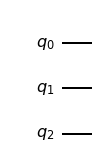

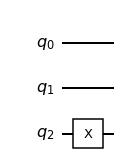

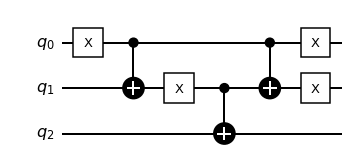

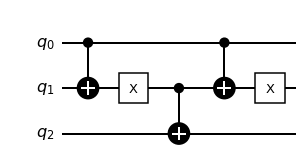

In [5]:
func_1 = function_1()
func_2 = function_2()
func_3 = function_3()
func_4 = function_4()
display(func_1.draw('mpl',style="bw", scale = 1))
display(func_2.draw('mpl',style="bw", scale = 1))
display(func_3.draw('mpl',style="bw", scale = 1))
display(func_4.draw('mpl',style="bw", scale = 1))

In [6]:
# refer to COMP90084 Week 6 Tutorial

# define the Deutsch-Jozsa function

def deutsch_josza(function=None, num_qubits = 3):
    x = QuantumRegister(num_qubits-1, "x")
    y = QuantumRegister(1, "y")
    Uf_input_measure = ClassicalRegister(num_qubits-1, "xMeasure")
    qc = QuantumCircuit(x, y, Uf_input_measure)
    
    # X gate on the function output qubit
    qc.x(y)
    qc.barrier()
    
    # H gate everywhere
    qc.h([*x, *y])
    qc.barrier()
    
    # append the function
    if function is None:
        f = Gate(name='placeholder', num_qubits=num_qubits, params=[])
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    else:
        f = function.to_instruction()
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    qc.h(x)
    qc.barrier()
    
    for i in range(num_qubits-1):
        qc.measure(x[i], Uf_input_measure[num_qubits-1-1-i])
    
    return qc


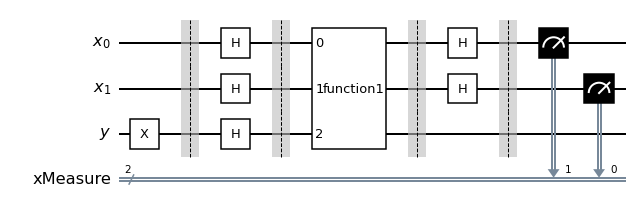

{'00': 2048}


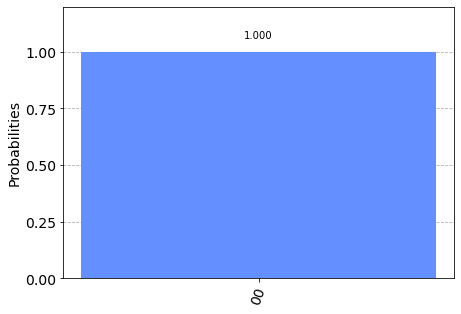

In [7]:
# insert the functions defined previouly

dj_1_qubit = deutsch_josza(func_1)
job_dj_1_qubit = backend_sim.run(transpile(dj_1_qubit, backend_sim), shots=2048)
result_dj_1_qubit = job_dj_1_qubit.result()
counts_dj_1_qubit = result_dj_1_qubit.get_counts(dj_1_qubit)
display(dj_1_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_1_qubit)
plot_histogram(counts_dj_1_qubit)

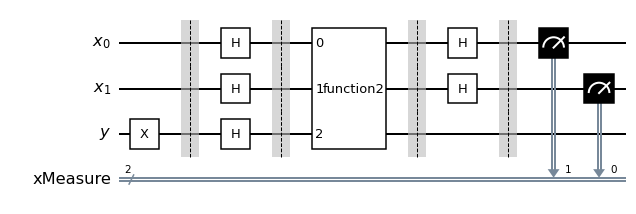

{'00': 2048}


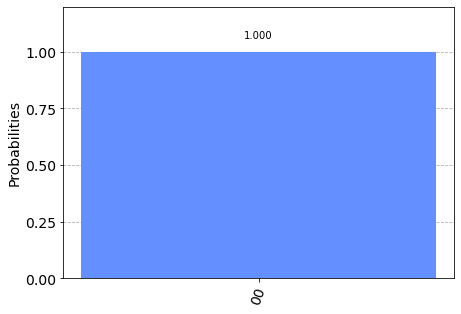

In [8]:
dj_2_qubit = deutsch_josza(func_2)
job_dj_2_qubit = backend_sim.run(transpile(dj_2_qubit, backend_sim), shots=2048)
result_dj_2_qubit = job_dj_2_qubit.result()
counts_dj_2_qubit = result_dj_2_qubit.get_counts(dj_2_qubit)
display(dj_2_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_2_qubit)
plot_histogram(counts_dj_2_qubit)

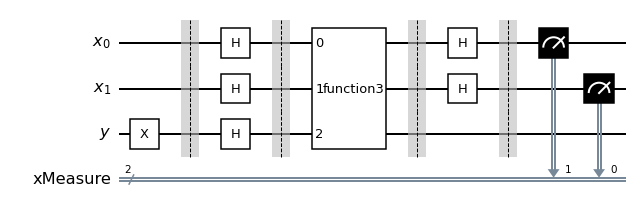

{'11': 2048}


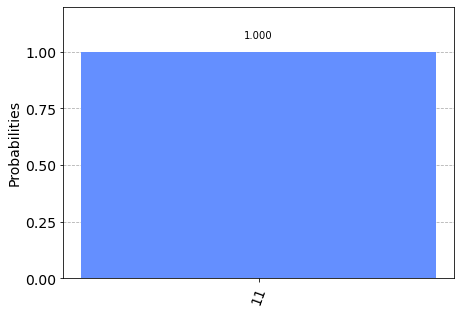

In [9]:
dj_3_qubit = deutsch_josza(func_3)
job_dj_3_qubit = backend_sim.run(transpile(dj_3_qubit, backend_sim), shots=2048)
result_dj_3_qubit = job_dj_3_qubit.result()
counts_dj_3_qubit = result_dj_3_qubit.get_counts(dj_3_qubit)
display(dj_3_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_3_qubit)
plot_histogram(counts_dj_3_qubit)

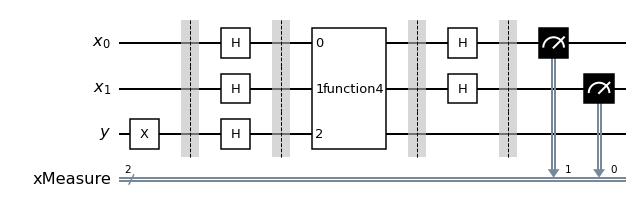

{'11': 2048}


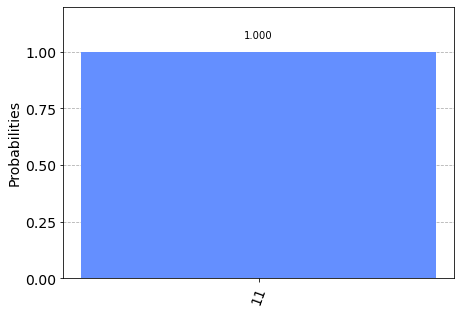

In [10]:
dj_4_qubit = deutsch_josza(func_4)
job_dj_4_qubit = backend_sim.run(transpile(dj_4_qubit, backend_sim), shots=2048)
result_dj_4_qubit = job_dj_4_qubit.result()
counts_dj_4_qubit = result_dj_4_qubit.get_counts(dj_4_qubit)
display(dj_4_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_4_qubit)
plot_histogram(counts_dj_4_qubit)

From the output, we can know that function 1 and 2 are constant; function 3 and 4 are balanced.

#### Qustion 1.2(b)

In [11]:
# define four given functions

def function_1b():
    qc = QuantumCircuit(4, name="function1")    
    return qc

def function_2b():
    qc = QuantumCircuit(4, name="function2")
    qc.x(3)
    return qc

def function_3b():
    qc = QuantumCircuit(4, name="function3")
    qc.x(0)
    qc.cx(0,1)
    qc.x(1)
    qc.cx(1,3)
    qc.cx(0,1)
    qc.x(0)
    qc.x(1)
    return qc

def function_4b():
    qc = QuantumCircuit(4, name="function4")
    qc.cx(0,1)
    qc.x(1)
    qc.cx(1,3)
    qc.cx(0,1)
    qc.x(1)
    return qc

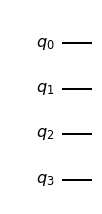

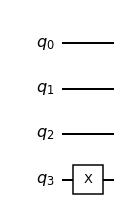

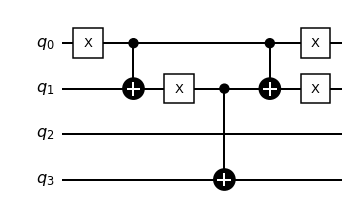

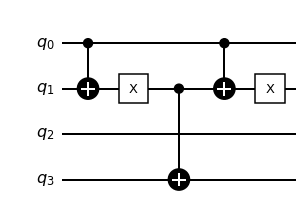

In [12]:
func_1b = function_1b()
func_2b = function_2b()
func_3b = function_3b()
func_4b = function_4b()
display(func_1b.draw('mpl',style="bw", scale = 1))
display(func_2b.draw('mpl',style="bw", scale = 1))
display(func_3b.draw('mpl',style="bw", scale = 1))
display(func_4b.draw('mpl',style="bw", scale = 1))

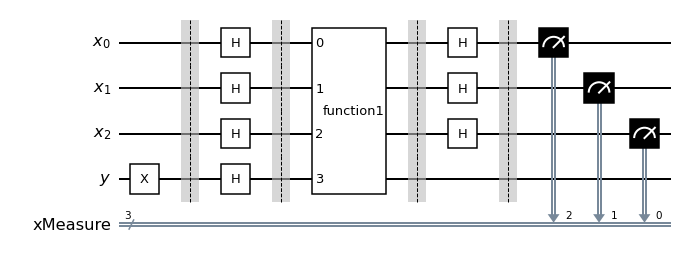

{'000': 2048}


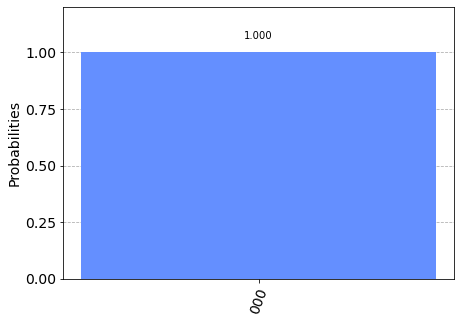

In [14]:
# insert the functions defined previouly

dj_1_qubit = deutsch_josza(func_1b, num_qubits = 4)
job_dj_1_qubit = backend_sim.run(transpile(dj_1_qubit, backend_sim), shots=2048)
result_dj_1_qubit = job_dj_1_qubit.result()
counts_dj_1_qubit = result_dj_1_qubit.get_counts(dj_1_qubit)
display(dj_1_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_1_qubit)
plot_histogram(counts_dj_1_qubit)

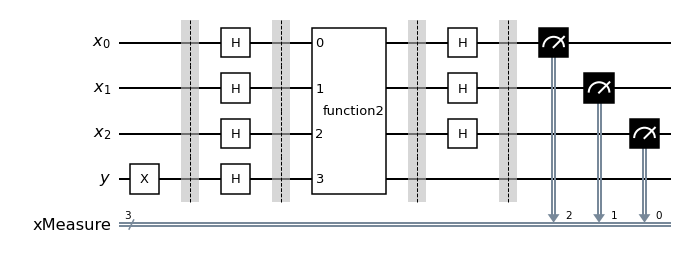

{'000': 2048}


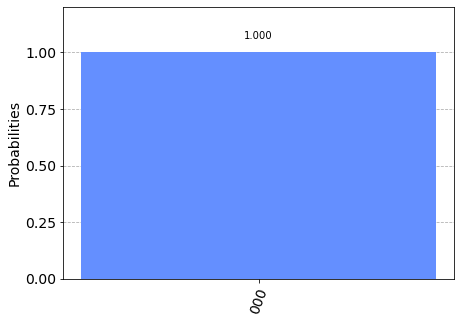

In [15]:
dj_2_qubit = deutsch_josza(func_2b, num_qubits = 4)
job_dj_2_qubit = backend_sim.run(transpile(dj_2_qubit, backend_sim), shots=2048)
result_dj_2_qubit = job_dj_2_qubit.result()
counts_dj_2_qubit = result_dj_2_qubit.get_counts(dj_2_qubit)
display(dj_2_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_2_qubit)
plot_histogram(counts_dj_2_qubit)

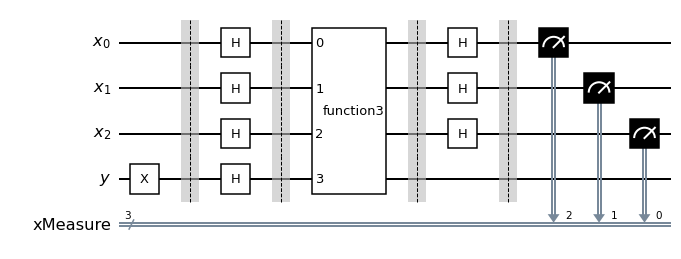

{'110': 2048}


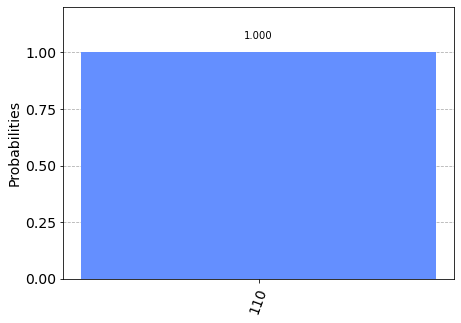

In [16]:
dj_3_qubit = deutsch_josza(func_3b, num_qubits = 4)
job_dj_3_qubit = backend_sim.run(transpile(dj_3_qubit, backend_sim), shots=2048)
result_dj_3_qubit = job_dj_3_qubit.result()
counts_dj_3_qubit = result_dj_3_qubit.get_counts(dj_3_qubit)
display(dj_3_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_3_qubit)
plot_histogram(counts_dj_3_qubit)

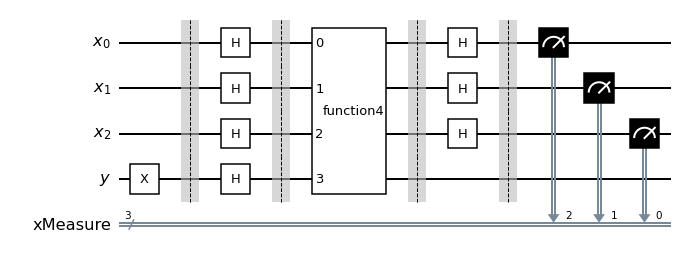

{'110': 2048}


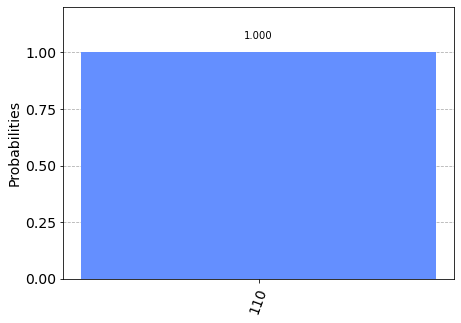

In [17]:
dj_4_qubit = deutsch_josza(func_4b, num_qubits = 4)
job_dj_4_qubit = backend_sim.run(transpile(dj_4_qubit, backend_sim), shots=2048)
result_dj_4_qubit = job_dj_4_qubit.result()
counts_dj_4_qubit = result_dj_4_qubit.get_counts(dj_4_qubit)
display(dj_4_qubit.draw('mpl',style="bw", scale = 1))
print(counts_dj_4_qubit)
plot_histogram(counts_dj_4_qubit)

From the output, we can know that function 1 and 2 are constant; function 3 and 4 are balanced.

### Question 1.3

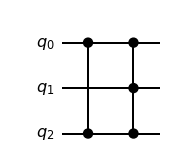

In [18]:
# First, we'll need to construct an oracle to mark states |101>

qc = QuantumCircuit(3)
qc.cz(0, 2)
qc = qc.compose(MCMT('cz', 2, 1))
oracle = qc.to_gate()
oracle.name = "Oracle"
qc.draw('mpl', style = "bw")

In [19]:
# created a general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.barrier()
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.barrier()
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    return qc

def diffuser_with_errors(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        qc.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        qc.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), qubit)
    # Do multi-controlled-Z gate
    qc.barrier()
    qc.h(nqubits-1)
    qc.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), nqubits-1)
    
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    qc.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), nqubits-1)
    qc.barrier()
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
        qc.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        qc.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), qubit)
    
    return qc

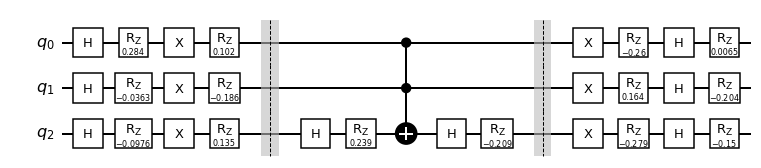

In [20]:
example_diffuser_with_errors = diffuser_with_errors(3)
example_diffuser_with_errors.draw('mpl', style='bw')

In [21]:
def construct_grover_circuit(with_error=False):
    if with_error:
        diffu_err = diffuser_with_errors(3).to_instruction()
        diffu_err.name = 'Diffuser_with_errors'
    else:
        diffu = diffuser_with_errors(3).to_instruction()
        diffu.name = 'Diffuser'
        
    grover_circuit = QuantumCircuit(3)

    for i in range(3):
        grover_circuit.h(i)
        if with_error:
            grover_circuit.rz(random.uniform(-0.1*np.pi, 0.1*np.pi), i)


    grover_circuit.barrier()
    grover_circuit.append(oracle, [0,1,2])
    
    if with_error:
        grover_circuit.append(diffu_err, [0,1,2])
    else:
        grover_circuit.append(diffu, [0,1,2])

    grover_circuit.measure_all()
    grover_circuit.draw('mpl', style='bw')
    
    return grover_circuit

In [22]:
def simulate_grover(with_err=False):
    grover_circuit = construct_grover_circuit(with_error=with_err)
    
    # simulate the circuit
    job = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1)
    result = job.result()
    counts = result.get_counts(grover_circuit)
    plot_histogram(counts)
    
    return counts
    

In [23]:
def get_counts(num):
    count_dict = {}
    for i in range(num):
        count = simulate_grover(with_err=True)
        count_key = list(count.keys())[0]
        if count_key in count_dict:
            count_dict[count_key] += 1
        else:
            count_dict.update(count)     
            
    return count_dict

#### Simulation result of errors in the circuit

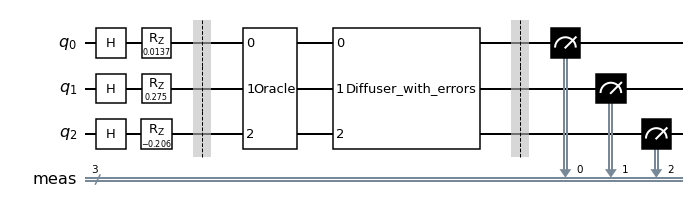

In [24]:
construct_grover_circuit(with_error=True).draw('mpl', style='bw')

In [25]:
counts_with_error = get_counts(1024)

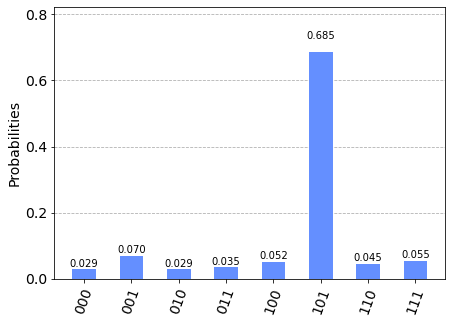

In [26]:
plot_histogram(counts_with_error)

#### Simulation result of no errors in the circuit

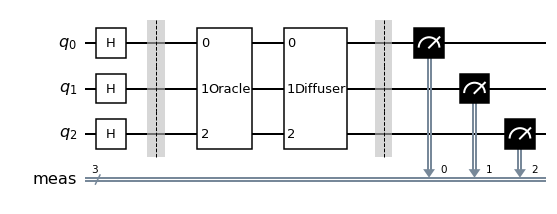

In [27]:
n = 3
diffu = diffuser(n).to_instruction()
diffu.name = 'Diffuser'
grover_circuit = QuantumCircuit(n)

for i in range(n):
    grover_circuit.h(i)

grover_circuit.barrier()
grover_circuit.append(oracle, [0,1,2])
grover_circuit.append(diffu, [0,1,2])

grover_circuit.measure_all()
grover_circuit.draw('mpl', style='bw')

{'101': 814, '011': 23, '000': 35, '110': 33, '100': 24, '010': 34, '111': 32, '001': 29}


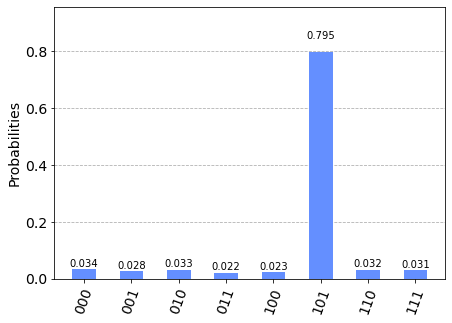

In [28]:
# simulate the circuit
job = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1024)
result = job.result()
counts = result.get_counts(grover_circuit)
print(counts)
plot_histogram(counts)

#### Conclusion

To reflect the randomness of errors in the circuit, the circuit with errors is simulated 1024 times with the error angles re-sampled each time, and the number of shots set to 1 for each simulation. From the result, it is shown that the error has the impact on the quantum algorithm’s fidelity with around 10% decrease.

To recover the fidelity of the quantum algorithm in such case, one of the simplest error correction schemes is to simply run the quantum circuit a number of times to get a probability distribution such that the result with the highest probability is the correct result. However, compared to such time-consuming method, a more active way to use of 2 ancillary qubits to correct bit flip errors on 1 qubit. The method applies CNOT gates to q1 and q2 (ancillary qubits) where the control qubit is q0. After that, the CNOT gates are repeated, and then a toffoli gate is applied to q0 where q1 and q2 are the control qubits.


### Question 1.4

In [29]:
# matrix needed for computation

I_2 = np.identity(2)
I_4 = np.identity(4)
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])

_00 = np.array([[1],[0],[0],[0]])
_01 = np.array([[0],[1],[0],[0]])
_10 = np.array([[0],[0],[1],[0]])
_11 = np.array([[0],[0],[0],[1]])

_0000 = np.kron(_00, _00)
_1111 = np.kron(_11, _11)
_0110 = np.kron(_01, _10)
_1001 = np.kron(_10, _01)
_1010 = np.kron(_10, _10)
_0101 = np.kron(_01, _01)
_1100 = np.kron(_11, _00)
_0011 = np.kron(_00, _11)

IXXI = np.kron(np.kron(np.kron(I_2, X), X), I_2)
ZIIZ = np.kron(np.kron(np.kron(Z, I_2), I_2), Z)
ZXXZ = np.kron(np.kron(np.kron(Z, X), X), Z)

XIXI = np.kron(np.kron(np.kron(X, I_2), X), I_2)
IZIZ = np.kron(np.kron(np.kron(I_2, Z), I_2), Z)
XZXZ = np.kron(np.kron(np.kron(X, Z), X), Z)

\begin{equation*}
    \begin{aligned}
    CNOT_{1,2} &= |00 \rangle \langle 00 | + |01 \rangle \langle 01 | + \
                |11 \rangle \langle 10 | + |10 \rangle \langle 11 | \\
               &= \frac{1}{2} (I \otimes I + Z \otimes I + I \otimes X - Z \otimes X) \\
    CNOT_{1,2 L} &= \frac{1}{2} (I \otimes I + Z_{1}Z_{4} \otimes I + \
                   I \otimes X_{2}X_{3} - Z_{1}Z_{4} \otimes X_{2}X_{3}) \\
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
    CNOT_{2,1} &= |00 \rangle \langle 00 | + |11 \rangle \langle 01 | + \
                |10 \rangle \langle 10 | + |01 \rangle \langle 11 | \\
               &= \frac{1}{2} (I \otimes I + I \otimes Z + X \otimes I - X \otimes Z) \\
    CNOT_{2,1(l)} &= \frac{1}{2} (I \otimes I + I \otimes Z_{2}Z_{4} + \
                   X_{1}X_{3} \otimes I - X_{1}X_{3} \otimes Z_{2}Z_{4}) \\
    \end{aligned}
\end{equation*}

#### For $|00\rangle$:

##### $CNOT_{1,2}$

\begin{aligned}
    CNOT_{1,2} |00\rangle &= \frac{1}{2} (I \otimes I + Z \otimes I + \
                            I \otimes X - Z \otimes X) \times |00\rangle \\
                          &= |00\rangle
\end{aligned}

Calculation as below:

In [30]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(Z, I_2) + np.kron(I_2, X) - np.kron(Z, X)), _00)

array([[1.],
       [0.],
       [0.],
       [0.]])

\begin{aligned}
    CNOT_{1,2 L} |00\rangle_{L} &= \frac{1}{2} (I \otimes I + Z_{1}Z_{4} \otimes I + \
                                   I \otimes X_{2}X_{3} - Z_{1}Z_{4} \otimes X_{2}X_{3}) \
                                   \times \frac{1}{\sqrt(2}(|0000\rangle + |1111\rangle) \\
                                &= \frac{1}{\sqrt(2}(|0000\rangle + |1111\rangle)
\end{aligned}

Calculation as below:

In [31]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + ZIIZ + IXXI - ZXXZ), (_0000 + _1111))

array([[0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678]])

In [32]:
1/np.sqrt(2)*(_0000 + _1111)

array([[0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678]])

##### $CNOT_{2,1}$

\begin{aligned}
    CNOT_{2,1} |00\rangle &= \frac{1}{2} (I \otimes I + I \otimes Z + \
                                X \otimes I + X \otimes Z) \times |00\rangle \\
                          &= |00\rangle
\end{aligned}

Calculation as below:

In [33]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(I_2, Z) + np.kron(X, I_2) - np.kron(X, Z)), _00)

array([[1.],
       [0.],
       [0.],
       [0.]])

\begin{aligned}
    CNOT_{2,1 L} |00\rangle_{L} &= \frac{1}{2} (I \otimes I + I \otimes Z_{2}Z_{4} + \
                                   X_{1}X_{3} \otimes I - X_{1}X_{3} \otimes Z_{2}Z_{4}) \
                                   \times \frac{1}{\sqrt(2}(|0000\rangle + |1111\rangle) \\
                                &= \frac{1}{\sqrt(2}(|0000\rangle + |1111\rangle)
\end{aligned}

Calculation as below:

In [34]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + IZIZ + XIXI - XZXZ), (_0000 + _1111))

array([[0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678]])

In [35]:
1/np.sqrt(2)*(_0000 + _1111)

array([[0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678]])

#### For $|01\rangle$:

##### $CNOT_{1,2}$

\begin{aligned}
    CNOT_{1,2} |01\rangle &= \frac{1}{2} (I \otimes I + Z \otimes I + \
                            I \otimes X - Z \otimes X) \times |01\rangle \\
                          &= |01\rangle
\end{aligned}

Calculation as below:


In [36]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(Z, I_2) + np.kron(I_2, X) - np.kron(Z, X)), _01)

array([[0.],
       [1.],
       [0.],
       [0.]])

\begin{aligned}
    CNOT_{1,2 L} |01\rangle_{L} &= \frac{1}{2} (I \otimes I + Z_{1}Z_{4} \otimes I + \
                                   I \otimes X_{2}X_{3} - Z_{1}Z_{4} \otimes X_{2}X_{3}) \
                                   \times \frac{1}{\sqrt(2}(|0110\rangle + |1001\rangle) \\
                                &= \frac{1}{\sqrt(2}(|0110\rangle + |1001\rangle)
\end{aligned}

Calculation as below:

In [37]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + ZIIZ + IXXI - ZXXZ), (_0110 + _1001))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [38]:
1/np.sqrt(2)*(_0110 + _1001)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

##### $CNOT_{2,1}$

\begin{aligned}
    CNOT_{2,1} |01\rangle &= \frac{1}{2} (I \otimes I + I \otimes Z + \
                                X \otimes I - X \otimes Z) \times |01\rangle \\
                          &= |11\rangle
\end{aligned}

Calculation as below:

In [39]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(I_2, Z) + np.kron(X, I_2) - np.kron(X, Z)), _01)

array([[0.],
       [0.],
       [0.],
       [1.]])

\begin{aligned}
    CNOT_{2,1 L} |01\rangle_{L} &= \frac{1}{2} (I \otimes I + I \otimes Z_{2}Z_{4} + \
                                   X_{1}X_{3} \otimes I - X_{1}X_{3} \otimes Z_{2}Z_{4}) \
                                   \times \frac{1}{\sqrt(2}(|0110\rangle + |1001\rangle) \\
                                &= \frac{1}{\sqrt(2}(|1100\rangle + |0011\rangle)
\end{aligned}

Calculation as below:

In [40]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + IZIZ + XIXI - XZXZ), (_0110 + _1001))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ]])

In [41]:
1/np.sqrt(2)*(_1100 + _0011)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ]])

#### For $|10\rangle$:

##### $CNOT_{1,2}$

\begin{aligned}
    CNOT_{1,2} |10\rangle &= \frac{1}{2} (I \otimes I + Z \otimes I + \
                            I \otimes X - Z \otimes X) \times |10\rangle \\
                          &= |11\rangle
\end{aligned}

Calculation as below:



In [42]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(Z, I_2) + np.kron(I_2, X) - np.kron(Z, X)), _10)

array([[0.],
       [0.],
       [0.],
       [1.]])

\begin{aligned}
    CNOT_{1,2 L} |10\rangle_{L} &= \frac{1}{2} (I \otimes I + Z_{1}Z_{4} \otimes I + \
                                   I \otimes X_{2}X_{3} - Z_{1}Z_{4} \otimes X_{2}X_{3}) \
                                   \times \frac{1}{\sqrt(2}(|1010\rangle + |0101\rangle) \\
                                &= \frac{1}{\sqrt(2}(|1100\rangle + |0011\rangle)
\end{aligned}

Calculation as below:

In [43]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + ZIIZ + IXXI - ZXXZ), (_1010 + _0101))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ]])

In [44]:
1/np.sqrt(2)*(_1100 + _0011)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ]])

##### $CNOT_{2,1}$

\begin{aligned}
    CNOT_{2,1} |10\rangle &= \frac{1}{2} (I \otimes I + I \otimes Z + \
                                X \otimes I - X \otimes Z) \times |10\rangle \\
                          &= |10\rangle
\end{aligned}

Calculation as below:

In [45]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(I_2, Z) + np.kron(X, I_2) - np.kron(X, Z)), _10)

array([[0.],
       [0.],
       [1.],
       [0.]])

\begin{aligned}
    CNOT_{2,1 L} |10\rangle_{L} &= \frac{1}{2} (I \otimes I + I \otimes Z_{2}Z_{4} + \
                                   X_{1}X_{3} \otimes I - X_{1}X_{3} \otimes Z_{2}Z_{4}) \
                                   \times \frac{1}{\sqrt(2}(|1010\rangle + |0101\rangle) \\
                                &= \frac{1}{\sqrt(2}(|1010\rangle + |0101\rangle)
\end{aligned}

Calculation as below:

In [46]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + IZIZ + XIXI - XZXZ), (_1010 + _0101))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [47]:
1/np.sqrt(2)*(_1010 + _0101)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

#### For $|11\rangle$:

##### $CNOT_{1,2}$

\begin{aligned}
    CNOT_{1,2} |11\rangle &= \frac{1}{2} (I \otimes I + Z \otimes I + \
                            I \otimes X - Z \otimes X) \times |11\rangle \\
                          &= |10\rangle
\end{aligned}


Calculation as below:

In [48]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(Z, I_2) + np.kron(I_2, X) - np.kron(Z, X)), _11)


array([[0.],
       [0.],
       [1.],
       [0.]])

\begin{aligned}
    CNOT_{1,2 L} |11\rangle_{L} &= \frac{1}{2} (I \otimes I + Z_{1}Z_{4} \otimes I + \
                                   I \otimes X_{2}X_{3} - Z_{1}Z_{4} \otimes X_{2}X_{3}) \
                                   \times \frac{1}{\sqrt(2}(|1100\rangle + |0011\rangle) \\
                                &= \frac{1}{\sqrt(2}(|1010\rangle + |0101\rangle)
\end{aligned}

Calculation as below:

In [49]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + ZIIZ + IXXI - ZXXZ), (_1100 + _0011))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [50]:
1/np.sqrt(2)*(_1010 + _0101)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

##### $CNOT_{2,1}$

\begin{aligned}
    CNOT_{2,1} |11\rangle &= \frac{1}{2} (I \otimes I + I \otimes Z + \
                                X \otimes I - X \otimes Z) \times |11\rangle \\
                          &= |01\rangle
\end{aligned}

Calculation as below:

In [51]:
1/2*np.matmul((np.kron(I_2, I_2) + np.kron(I_2, Z) + np.kron(X, I_2) - np.kron(X, Z)), _11)

array([[0.],
       [1.],
       [0.],
       [0.]])

\begin{aligned}
    CNOT_{2,1 L} |11\rangle_{L} &= \frac{1}{2} (I \otimes I + I \otimes Z_{2}Z_{4} + \
                                   X_{1}X_{3} \otimes I - X_{1}X_{3} \otimes Z_{2}Z_{4}) \
                                   \times \frac{1}{\sqrt(2}(|1100\rangle + |0011\rangle) \\
                                &= \frac{1}{\sqrt(2}(|0110\rangle + |1001\rangle)
\end{aligned}

Calculation as below:

In [52]:
1/2*1/np.sqrt(2)*np.matmul((np.kron(I_4, I_4) + IZIZ + XIXI - XZXZ), (_1100 + _0011))

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [53]:
1/np.sqrt(2)*(_0110 + _1001)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

## Question 2

### Question 2(a)

In [11]:
iris = datasets.load_iris()

col_1 = np.array(iris.data[:,0])
col_2 = np.array(iris.data[:,1])
col_3 = np.array(iris.data[:,2])
col_4 = np.array(iris.data[:,3])

# standardise the data
col_1 = col_1 - np.mean(col_1)
col_2 = col_2 - np.mean(col_2)
col_3 = col_3 - np.mean(col_3)
col_4 = col_4 - np.mean(col_4)

iris.data[:,0] = col_1
iris.data[:,1] = col_2
iris.data[:,2] = col_3
iris.data[:,3] = col_4

iris_data_cov_mat = np.cov(np.array(iris.data.T))
print("iris_data_cov_mat:\n", iris_data_cov_mat)

iris_data_cov_mat:
 [[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]


In [12]:
# normalize the covariance matrix
rho = iris_data_cov_density_mat = iris_data_cov_mat/np.trace(iris_data_cov_mat)
print("rho:\n", rho)

density_matrix = la.expm(2*np.pi*1j*rho)
print("\ne^2pi*i*rho:\n", density_matrix)

eigenvalues, eigenvectors = eig(density_matrix)
print("\neigenvalues:\n", eigenvalues)
print("\neigenvectors:\n", eigenvectors)

rho:
 [[ 0.14994532 -0.00927934  0.27866333  0.11289647]
 [-0.00927934  0.04154411 -0.07208823 -0.02659972]
 [ 0.27866333 -0.07208823  0.68145793  0.28331983]
 [ 0.11289647 -0.02659972  0.28331983  0.12705264]]

e^2pi*i*rho:
 [[ 0.95987297+0.12111623j -0.02097918+0.13021024j -0.02747432-0.18818283j
  -0.00981929-0.10156707j]
 [-0.02097918+0.13021024j  0.96773497+0.21291705j  0.01459751+0.00150838j
   0.00461572+0.02288817j]
 [-0.02747432-0.18818283j  0.01459751+0.00150838j  0.91739894-0.31674232j
  -0.03455543-0.14309588j]
 [-0.00981929-0.10156707j  0.00461572+0.02288817j -0.03455543-0.14309588j
   0.98353158-0.00613646j]]

eigenvalues:
 [0.88991637-0.45612372j 0.94492644+0.32728278j 0.99423185+0.10725217j
 0.9994638 +0.03274326j]

eigenvectors:
 [[ 0.36138659+4.23519157e-16j  0.65658877-5.18897781e-16j
  -0.58202985+4.59400255e-16j  0.31548719+4.57208127e-15j]
 [-0.08452251-3.25689832e-16j  0.73016143+0.00000000e+00j
   0.59791083+0.00000000e+00j -0.3197231 -4.24557099e-15j]
 [ 0.8566

#### Decomposation

In [13]:
U = UnitaryGate(la.expm(2*np.pi*1j*rho), label = 'U').control()

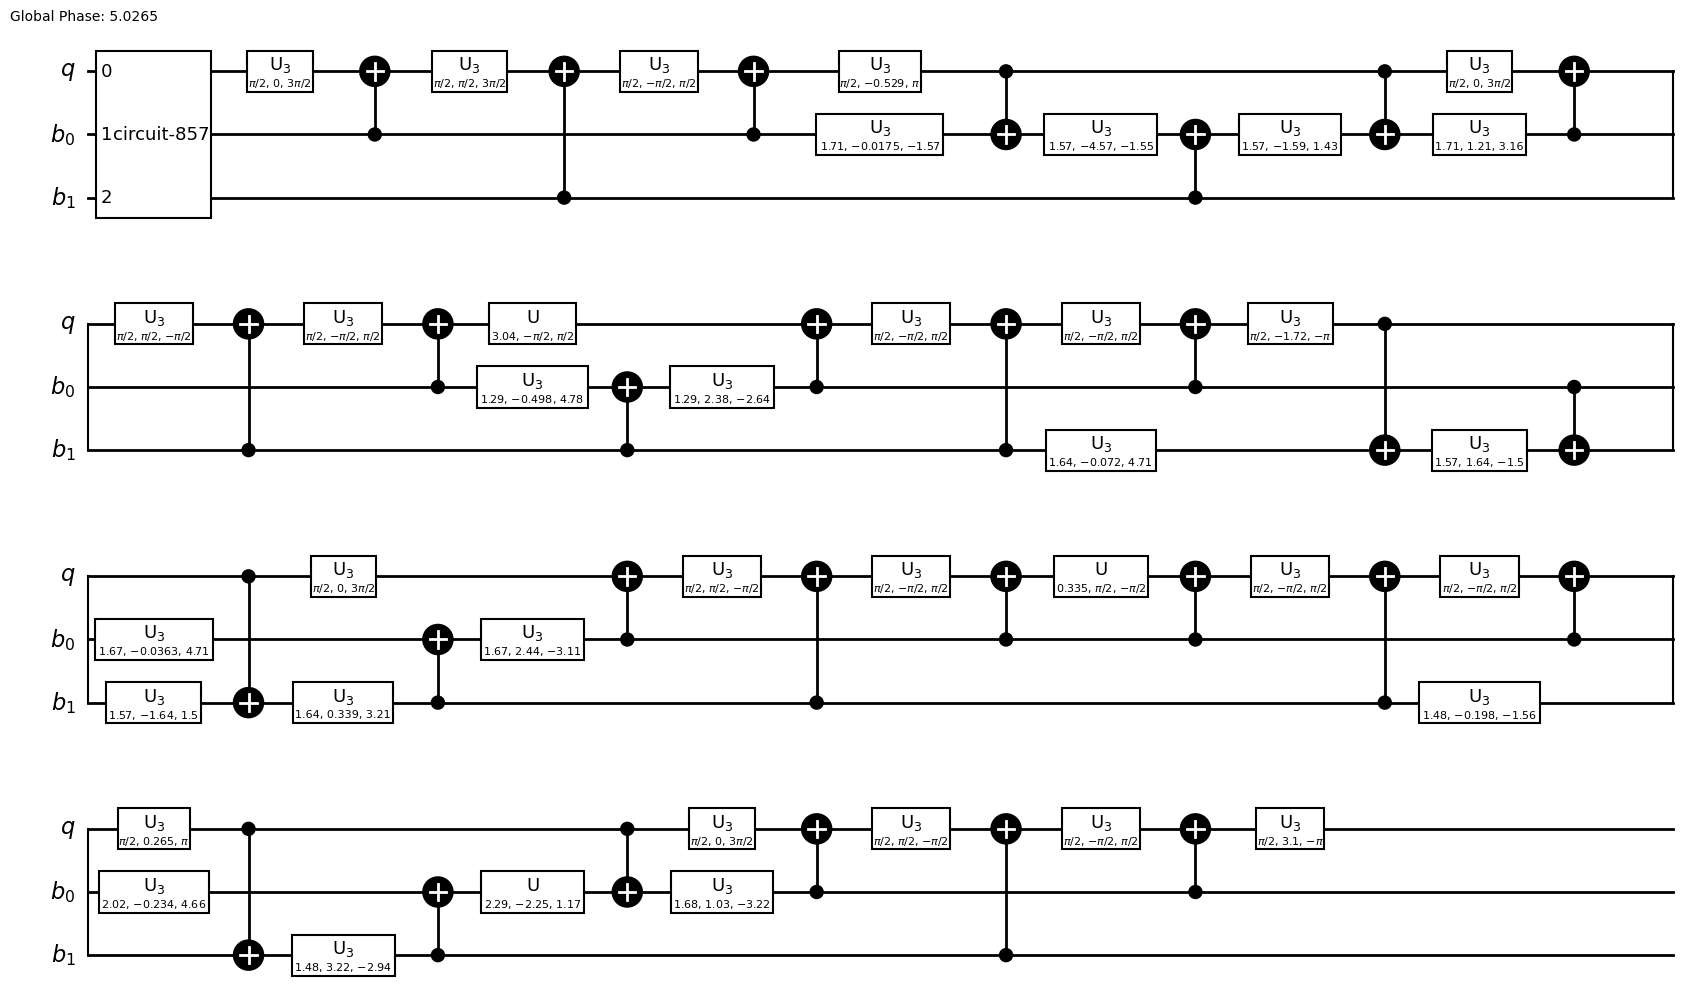

In [14]:
q = QuantumRegister(1, "q")
b = QuantumRegister(2, "b")
qc = QuantumCircuit(q, b)
qc.append(U, [0 ,1, 2])
transpile(qc, backend_sv).decompose().draw('mpl', style="bw")

### Question 2(b)

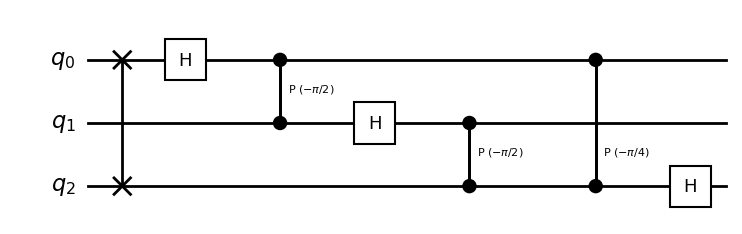

In [15]:
def IQFT(circ, q):
    '''
    Inverse quantum fourier transform (IQFT) applied to 
    a general quantum register 'q' of a circuit 'circ'
    '''
    n = len(q)
    
    for i in range(n//2):
        circ.swap(q[i], q[n-1-i])
    for i in range(n):
        for j in range(1, i+1):
            circ.cp(-np.pi/(2**j), q[i-j], q[i])
        circ.h(q[i])
    
q = QuantumRegister(3, 'q')
circ = QuantumCircuit(q)
IQFT(circ, q)
circ.draw('mpl', style="bw")

In [16]:
def QPE(n_qubits, iterations=1, psi_in=None, measure_psi=True):
    
    if measure_psi:
        q = QuantumRegister(n_qubits, "q")
        b = QuantumRegister(2, "b")
        c = ClassicalRegister(2, "c")
        ps = ClassicalRegister(n_qubits*iterations, "ps")
        qc = QuantumCircuit(q, b, c, ps)
    else:
        q = QuantumRegister(n_qubits, "q")
        b = QuantumRegister(2, "b")
        ps = ClassicalRegister(n_qubits*iterations, "ps")
        qc = QuantumCircuit(q, b, ps)
    
    cq_index = 0
    for _iter in range(iterations):
        if _iter == 0:
            if len(psi_in) == 4:
                qc.initialize(psi_in, b)
            if len(psi_in) == 2:
                qc.initialize(psi_in[0], n_qubits)
                qc.initialize(psi_in[1], n_qubits+1)

        qc.barrier()

        for i in range(n_qubits):
            qc.initialize([1,0], i)
        qc.h([*q])
        qc.barrier()

        for i in range(n_qubits):
            for j in range(2**(i)):
                qc.append(U, [i, *b])
        qc.barrier()

        IQFT(qc, q)
        qc.barrier()
            
        for i in range(n_qubits):
            qc.measure(q[i], ps[cq_index+i])
            
        cq_index += n_qubits

        # qc.barrier()
      
    if measure_psi:
        for i in range(2):
            qc.measure(b[i], c[i])

    return qc

In [17]:
principle_eigenvector = eigenvectors[list(eigenvalues).index(max(eigenvalues))]
principle_eigenvector

array([ 0.3582892 -5.68221855e-17j, -0.07548102+1.57565021e-16j,
        0.54583143+3.54838357e-15j,  0.75365743+0.00000000e+00j])

#### One iteration - $|\psi^{(1)}_{out}\rangle$

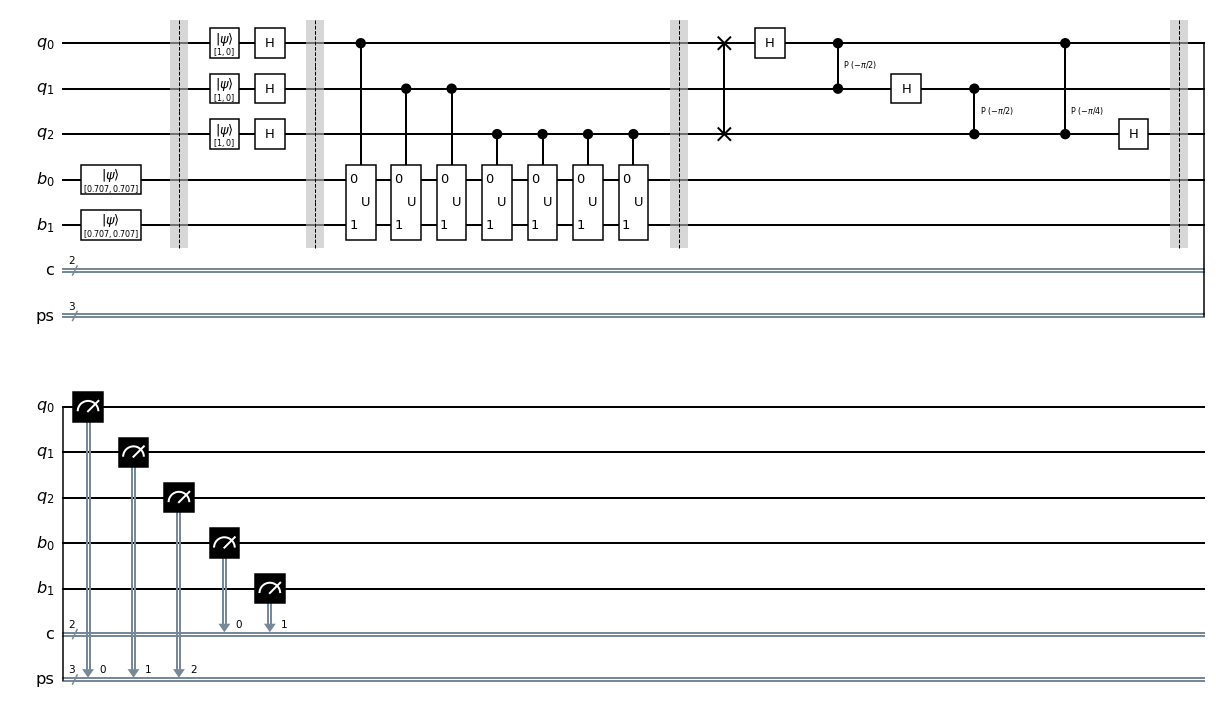

In [190]:
n_qubits = 3
iterations = 1
psi_in=[[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]]

qpe1 = QPE(n_qubits = n_qubits, iterations = iterations, psi_in=psi_in)
qpe1.draw('mpl', style="bw")

{'111 10': 893, '111 11': 158, '111 01': 21, '111 00': 319}

Approx eigenvector:
 [0.2293314162473041, 0.01509705248023005, 0.6419841840402588, 0.11358734723220705]


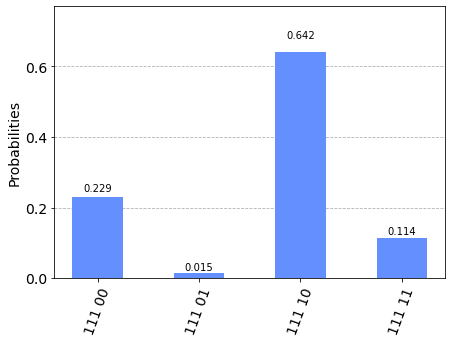

In [191]:
job = backend_sv.run(transpile(qpe1, backend_sv), shots=4096)
result = job.result()
counts = result.get_counts(qpe1)
# psi_out = partial_trace(result.get_statevector(), [0,1,2])
# print("\nState output:\n", np.real_if_close(psi_out.data))

for k in list(counts.keys()):
    if not k.startswith(n_qubits*iterations*'1' + ' '):
        counts.pop(k, None)
        
# print("\nClassical information after QPE:", counts.keys())
print(counts)

approx_eigenvector = [counts[key]/sum(counts.values()) for key in sorted(counts)]
print("\nApprox eigenvector:\n", approx_eigenvector)

plot_histogram(counts)


In [192]:
fidelity1 = state_fidelity(Statevector(principle_eigenvector), Statevector(np.sqrt(approx_eigenvector)))
print("Fidelity between first order approximation and the principal eigenvector:\n", fidelity1)

Fidelity between first order approximation and the principal eigenvector:
 0.7287179152866039


#### Two iterations - $|\psi^{(2)}_{out}\rangle$

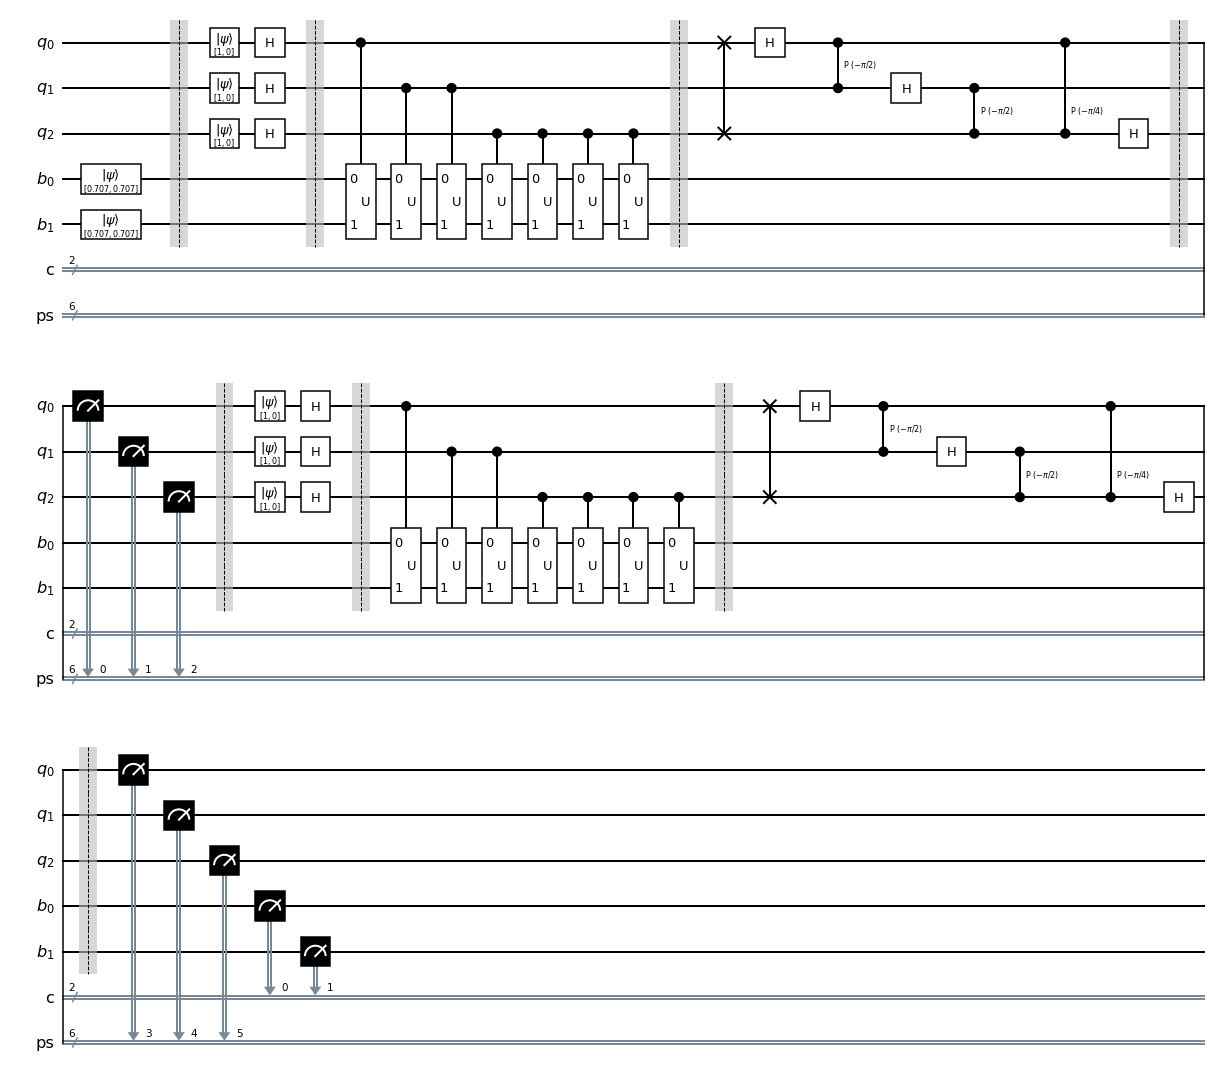

In [186]:
n_qubits = 3
iterations = 2
psi_in=[[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]]

qpe2 = QPE(n_qubits = n_qubits, iterations = iterations, psi_in=psi_in)
qpe2.draw('mpl', style="bw")

{'111111 00': 273, '111111 10': 1140, '111111 11': 184, '111111 01': 5}

Approx eigenvector:
 [0.1704119850187266, 0.003121098626716604, 0.7116104868913857, 0.11485642946317104]


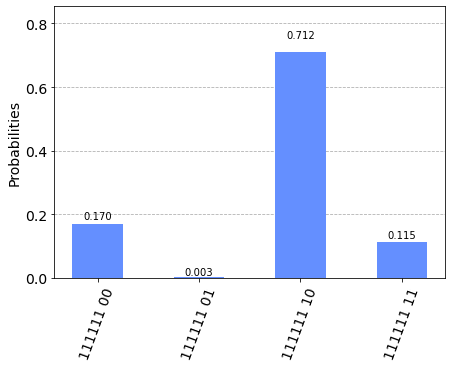

In [187]:
job = backend_sv.run(transpile(qpe2, backend_sv), shots=8192)
result = job.result()
counts = result.get_counts(qpe2)
# psi_out = partial_trace(result.get_statevector(), [0,1,2])
# print("\nState output:\n", np.real_if_close(psi_out.data))

for k in list(counts.keys()):
    if not k.startswith(n_qubits*iterations*'1' + ' '):
        counts.pop(k, None)
        
# print("\nClassical information after QPE:", counts.keys())
print(counts)

approx_eigenvector = [counts[key]/sum(counts.values()) for key in sorted(counts)]
print("\nApprox eigenvector:\n", approx_eigenvector)

plot_histogram(counts)

In [188]:
fidelity2 = state_fidelity(Statevector(principle_eigenvector), Statevector(np.sqrt(approx_eigenvector)))
print("Fidelity between first order approximation and the principal eigenvector:\n", fidelity2)

Fidelity between first order approximation and the principal eigenvector:
 0.7388323584908354


#### Three iterations - $|\psi^{(3)}_{out}\rangle$

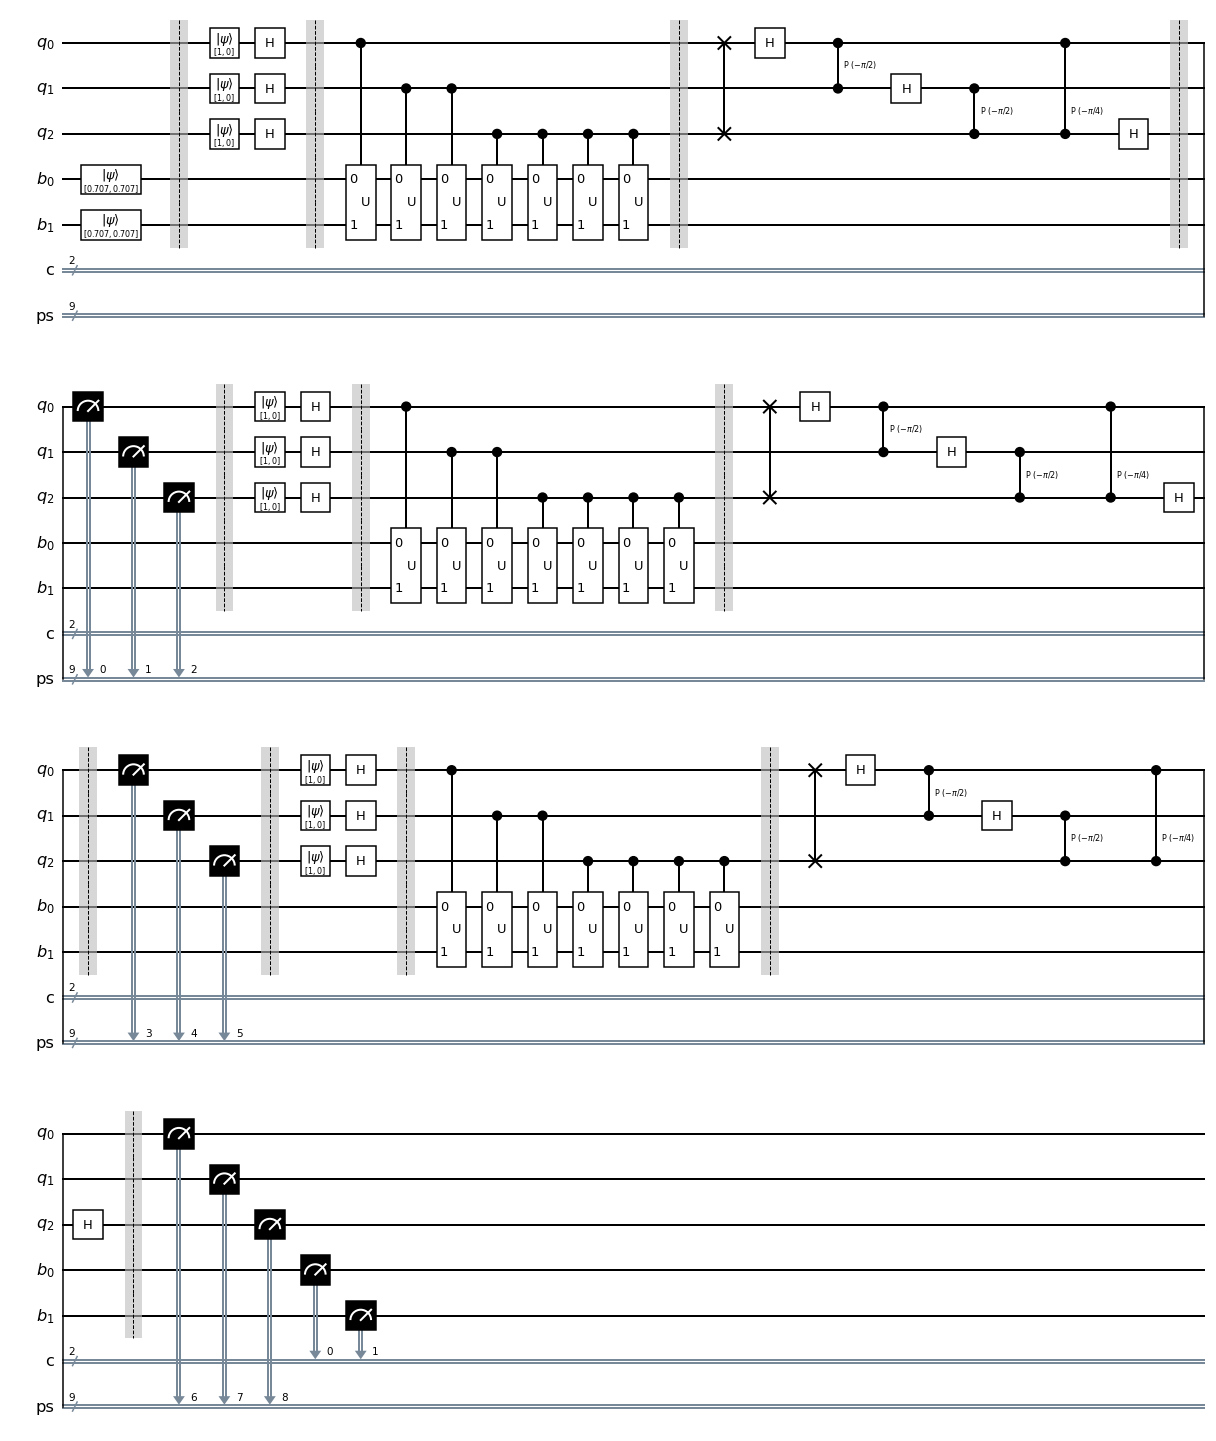

In [206]:
n_qubits = 3
iterations = 3
psi_in=[[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]]

qpe3 = QPE(n_qubits = n_qubits, iterations = iterations, psi_in=psi_in)
qpe3.draw('mpl', style="bw")

{'111111111 10': 4846, '111111111 00': 876, '111111111 11': 819, '111111111 01': 35}

Approx eigenvector:
 [0.1332116788321168, 0.005322384428223844, 0.7369221411192214, 0.12454379562043795]


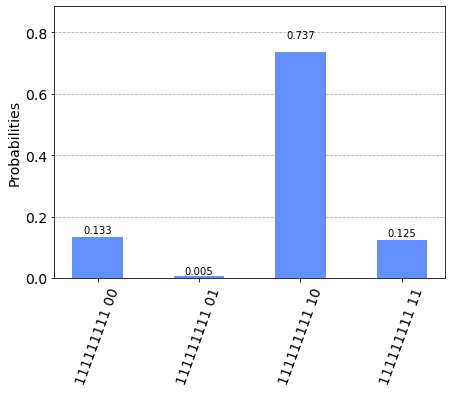

In [200]:
job = backend_sv.run(transpile(qpe3, backend_sv), shots=60000)
result = job.result()
counts = result.get_counts(qpe3)
# psi_out = partial_trace(result.get_statevector(), [0,1,2])
# print("\nState output:\n", np.real_if_close(psi_out.data))

for k in list(counts.keys()):
    if not k.startswith(n_qubits*iterations*'1' + ' '):
        counts.pop(k, None)
        
# print("\nClassical information after QPE:", counts.keys())
print(counts)

approx_eigenvector = [counts[key]/sum(counts.values()) for key in sorted(counts)]
print("\nApprox eigenvector:\n", approx_eigenvector)

plot_histogram(counts)

In [201]:
fidelity3 = state_fidelity(Statevector(principle_eigenvector), Statevector(np.sqrt(approx_eigenvector)))
print("Fidelity between first order approximation and the principal eigenvector:\n", fidelity3)

Fidelity between first order approximation and the principal eigenvector:
 0.7392530142992491


#### Four iterations - $|\psi^{(4)}_{out}\rangle$

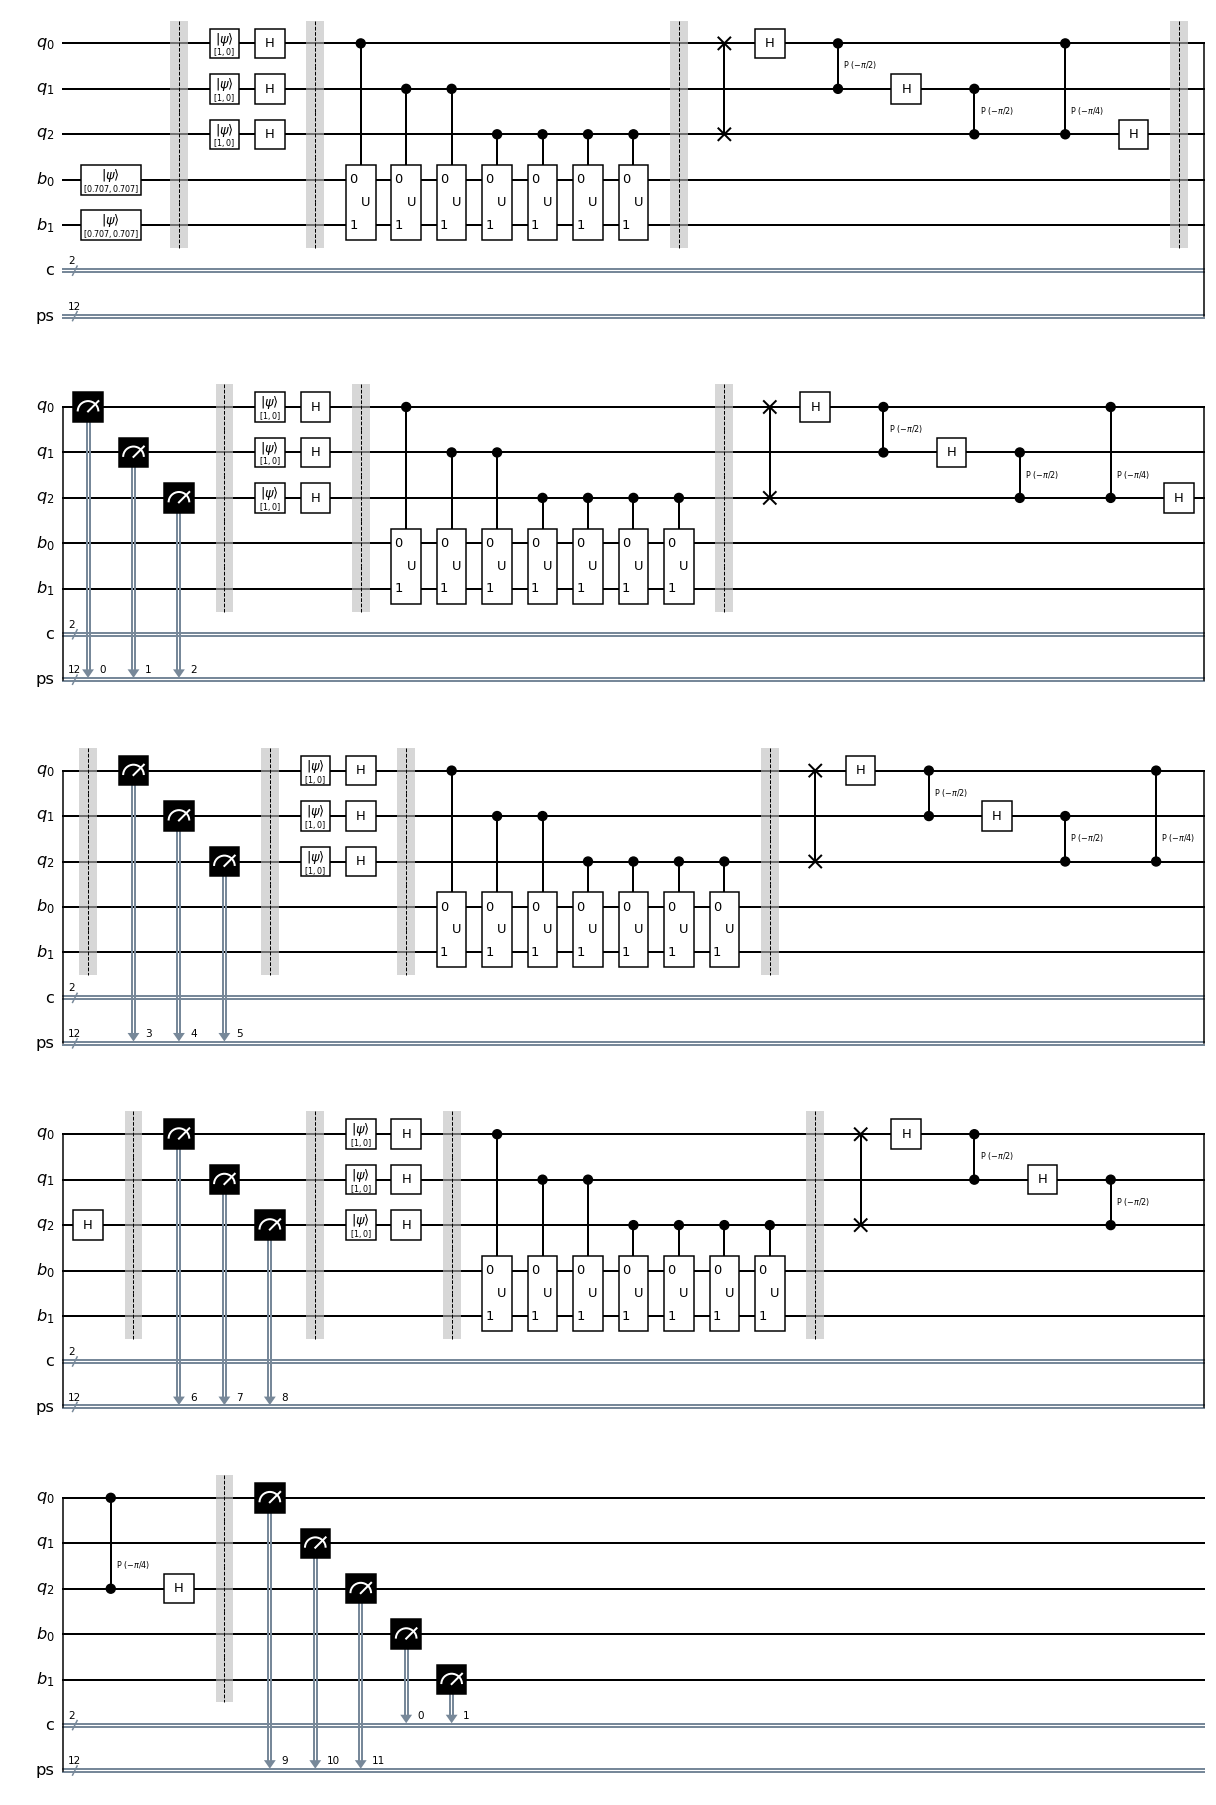

In [193]:
n_qubits = 3
iterations = 4
psi_in=[[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)]]

qpe4 = QPE(n_qubits = n_qubits, iterations = iterations, psi_in=psi_in)
qpe4.draw('mpl', style="bw")

{'111111111111 10': 3711, '111111111111 00': 695, '111111111111 11': 646, '111111111111 01': 33}

Approx eigenvector:
 [0.13667649950835792, 0.006489675516224189, 0.7297935103244838, 0.12704031465093413]


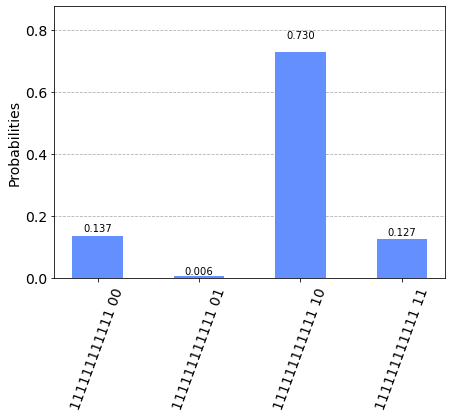

In [194]:
job = backend_sv.run(transpile(qpe4, backend_sv), shots=80000)
result = job.result()
counts = result.get_counts(qpe4)
# psi_out = partial_trace(result.get_statevector(), [0,1,2])
# print("\nState output:\n", np.real_if_close(psi_out.data))

for k in list(counts.keys()):
    if not k.startswith(n_qubits*iterations*'1' + ' '):
        counts.pop(k, None)
        
# print("\nClassical information after QPE:", counts.keys())
print(counts)

approx_eigenvector = [counts[key]/sum(counts.values()) for key in sorted(counts)]
print("\nApprox eigenvector:\n", approx_eigenvector)

plot_histogram(counts)

In [195]:
fidelity4 = state_fidelity(Statevector(principle_eigenvector), Statevector(np.sqrt(approx_eigenvector)))
print("Fidelity between first order approximation and the principal eigenvector:\n", fidelity4)

Fidelity between first order approximation and the principal eigenvector:
 0.7418285486816069


### Question 2(c)

In [287]:
largest = principle_eigenvector
second_largest = eigenvectors[list(eigenvalues).index(sorted(eigenvalues)[-2])]

#### For the largest eigenvalue of $\rho$

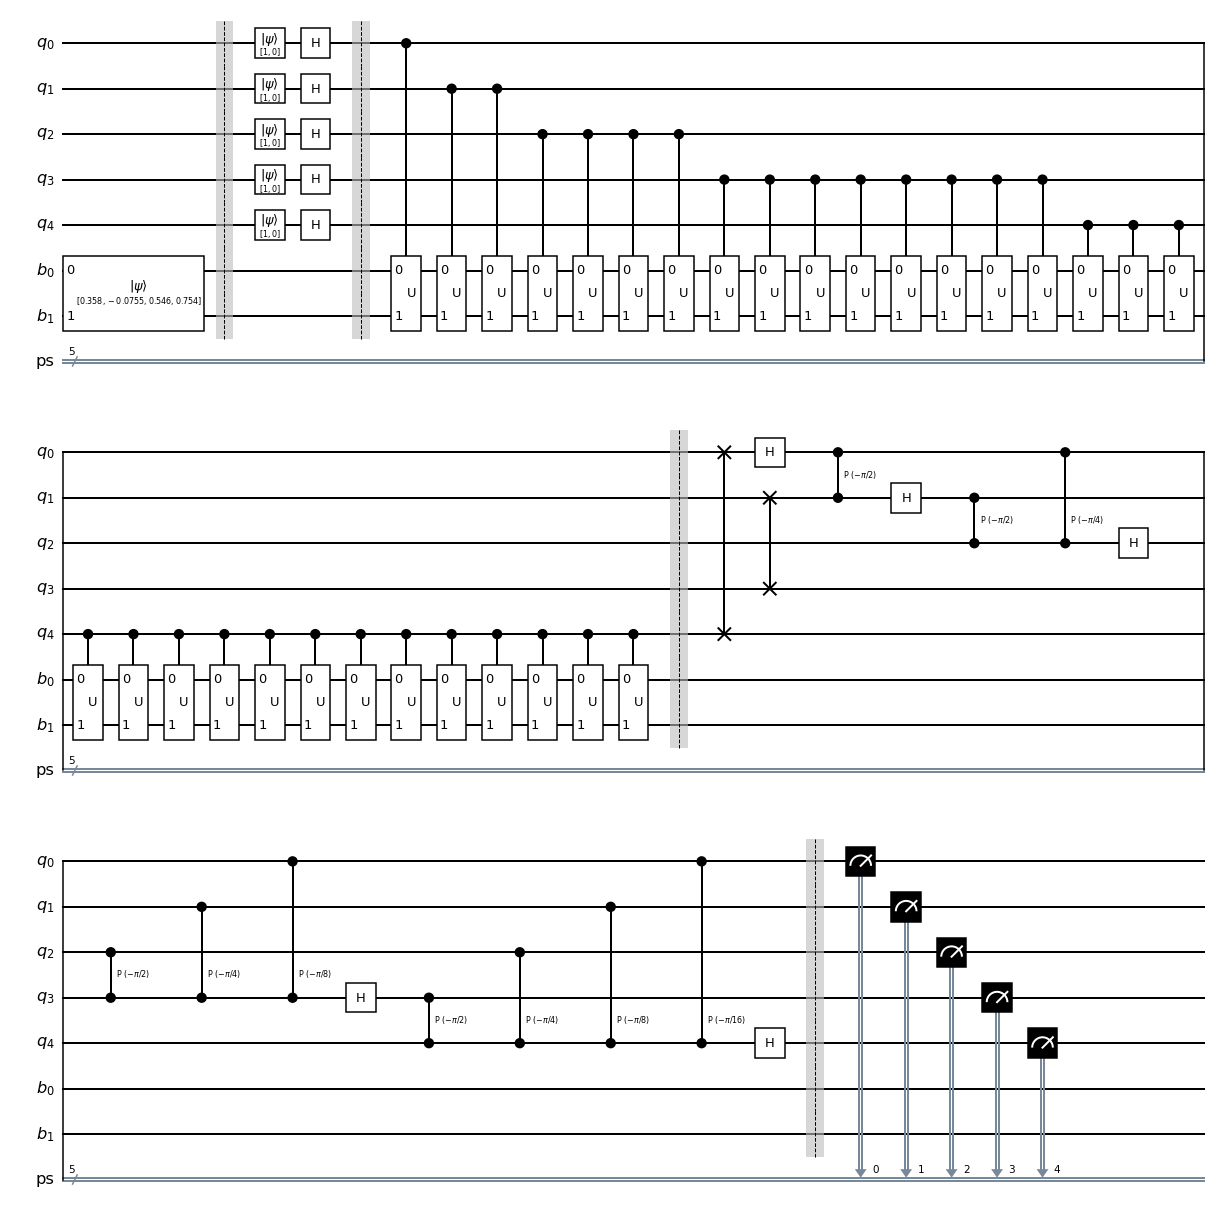

In [294]:
n_qubits = 5
iterations = 1
psi_in = largest

qpe5 = QPE(n_qubits = n_qubits, iterations = iterations, psi_in=psi_in, measure_psi=False)
qpe5.draw('mpl', style="bw")

In [295]:
job = backend_sv.run(transpile(qpe5, backend_sv), shots=8196)
result = job.result()
counts = result.get_counts(qpe5)
# psi_out = partial_trace(result.get_statevector(), [0,1,2])
# print("\nState output:\n", np.real_if_close(psi_out.data))

# print("\nClassical information after QPE:", counts.keys())
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
print(sorted_counts)

print("\nThe most frequent measurement on the top 5 registers, |k> is:", 
      max(sorted_counts, key=sorted_counts.get))

# approx_eigenvector = [counts[key]/sum(counts.values()) for key in sorted(counts)]
# print("\nApprox eigenvector:\n", approx_eigenvector)

# plot_histogram(counts)

{'11110': 3523, '11101': 1692, '00000': 1673, '11111': 377, '00001': 255, '11100': 211, '11011': 65, '00010': 62, '11010': 56, '11001': 35, '00011': 26, '10111': 21, '11000': 20, '00100': 20, '00101': 19, '10110': 17, '10101': 15, '00111': 13, '01011': 12, '00110': 11, '10100': 10, '10010': 8, '01100': 8, '01111': 8, '01101': 7, '10001': 6, '01110': 5, '01001': 5, '10011': 5, '10000': 4, '01000': 4, '01010': 3}

The most frequent measurement on the top 5 registers, |k> is: 11110


#### For the largest eigenvalue of $\rho$

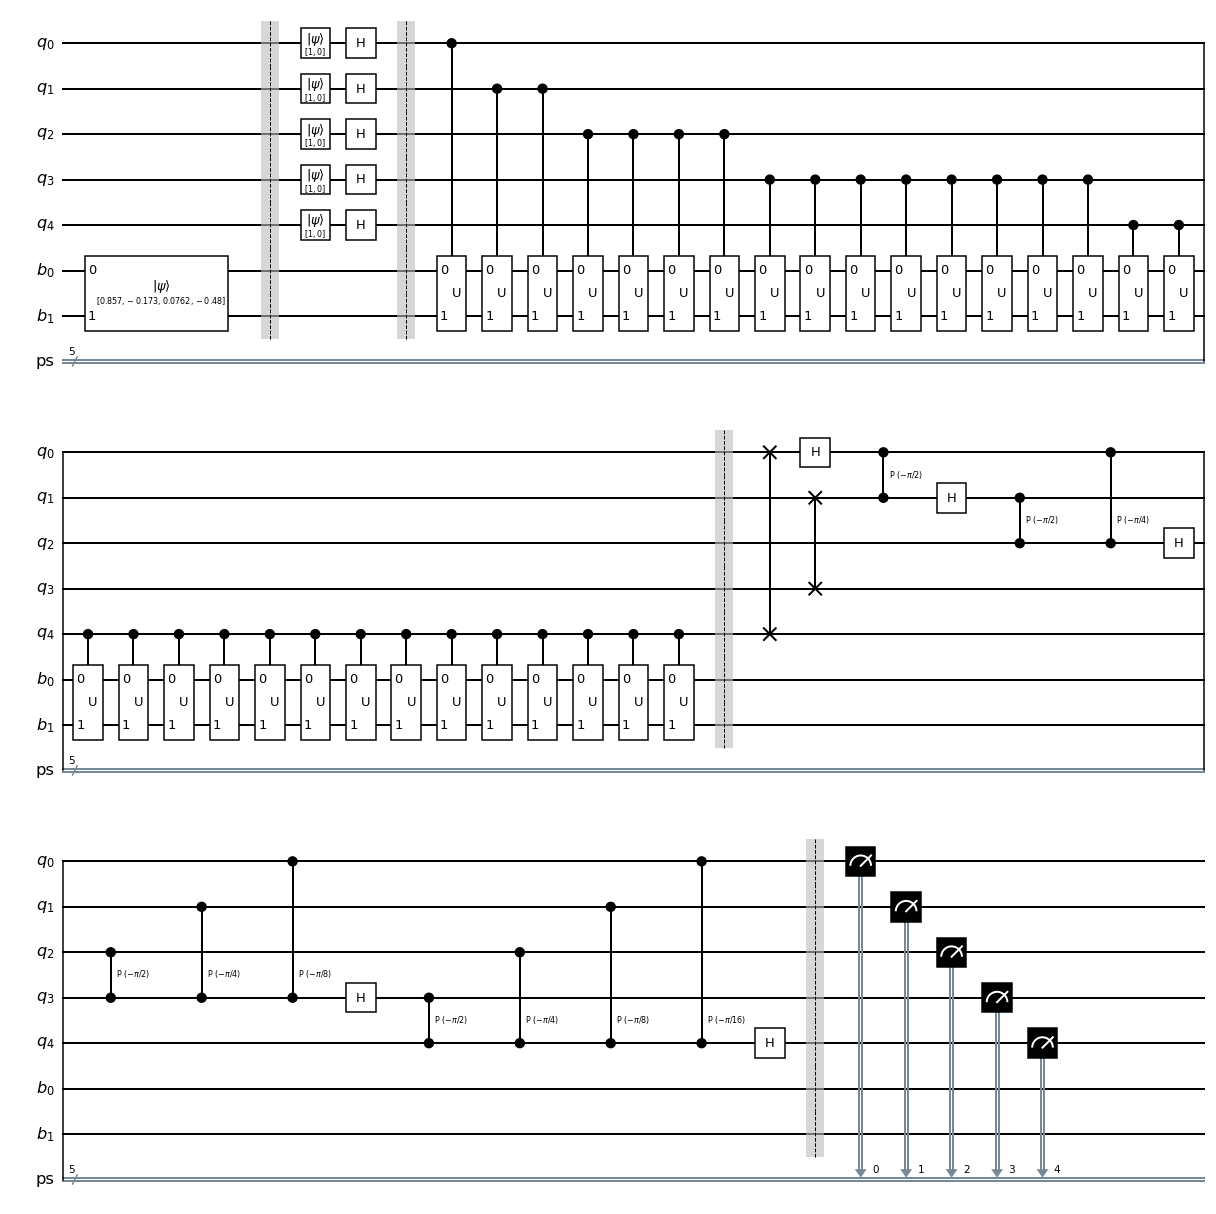

In [288]:
n_qubits = 5
iterations = 1
psi_in = second_largest

qpe5 = QPE(n_qubits = n_qubits, iterations = iterations, psi_in=psi_in, measure_psi=False)
qpe5.draw('mpl', style="bw")

In [289]:
job = backend_sv.run(transpile(qpe5, backend_sv), shots=8192)
result = job.result()
counts = result.get_counts(qpe5)
# psi_out = partial_trace(result.get_statevector(), [0,1,2])
# print("\nState output:\n", np.real_if_close(psi_out.data))

# print("\nClassical information after QPE:", counts.keys())
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
print(sorted_counts)

print("\nThe most frequent measurement on the top 5 registers, |k> is:", 
      max(sorted_counts, key=sorted_counts.get))

# approx_eigenvector = [counts[key]/sum(counts.values()) for key in sorted(counts)]
# print("\nApprox eigenvector:\n", approx_eigenvector)

# plot_histogram(counts)

{'00001': 3162, '00000': 2119, '00010': 1550, '11110': 335, '11111': 297, '00011': 159, '11101': 144, '00100': 62, '00101': 46, '11100': 42, '00110': 38, '00111': 30, '11011': 24, '11010': 24, '11001': 16, '01000': 15, '01001': 14, '11000': 13, '01110': 11, '10111': 9, '10100': 9, '01010': 9, '01111': 8, '10101': 8, '01011': 8, '10011': 7, '01100': 7, '10000': 7, '10001': 6, '10110': 6, '01101': 5, '10010': 2}

The most frequent measurement on the top 5 registers, |k> is: 00001


## Question 3

### Question 3.1

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

#### Question 3.1(a)

In [3]:
r = 0.04
sigma = 0.125
S_0 = 2
T = 300/365

def P(S_T):
    ans = 1/(S_T * sigma * np.sqrt(2*np.pi*T)) * \
            np.exp(-(np.log(S_T) - np.log(S_0) \
            - T*(r - sigma**2 / 2))**2 / (2*sigma**2*T)) 
    return ans


In [4]:
S_T_min = 1.5
S_T_max = 2.5
num_data = 8
interval = (S_T_max - S_T_min) / (num_data - 1)

# Discretize
S_Ti_list = []
P_S_Ti = []
for i in range(0, num_data):
    S_Ti = S_T_min + i * interval 
    p = P(S_Ti)
    S_Ti_list.append(S_Ti)
    P_S_Ti.append(p)
    

In [5]:
sum_P = 0
for p in P_S_Ti:
    sum_P += p

amplitudes = []
for p in P_S_Ti:
    amplitudes.append(np.sqrt(p/sum_P))
    

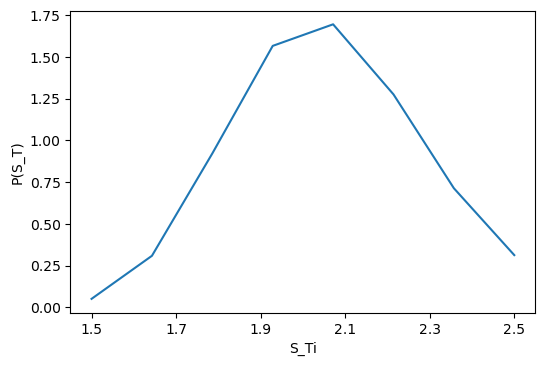

In [6]:
plt.plot(S_Ti_list, P_S_Ti)
plt.xticks(np.arange(min(S_Ti_list), max(S_Ti_list)+0.1, 0.2))
plt.xlabel('S_Ti')
plt.ylabel('P(S_T)')
plt.show()

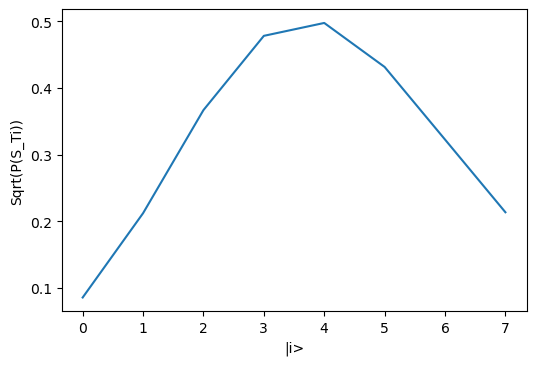

In [7]:
plt.plot(amplitudes)
plt.xlabel('|i>')
plt.ylabel('Sqrt(P(S_Ti))')
plt.show()

#### Question 3.1(b)

In [8]:
dev = qml.device("default.qubit", wires=3) 

def statepreparation(a):
    qml.RY(a[0], wires=0)
    qml.RX(a[1], wires=0)
    qml.RY(a[2], wires=1)
    qml.RX(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=2)
    qml.RX(a[5], wires=2)
    qml.CNOT(wires=[0, 2])

In [9]:
@qml.qnode(dev)
def circuit(angles):
    for a in angles:
        statepreparation(a)
    return qml.probs(wires=[0, 1, 2])

def loss_function(P_i_theta, P_S_ti):
    _sum = 0 
    for i in range(len(P_i_theta)):
        _sum += P_i_theta[i] * P_S_ti[i]
    loss = abs(1 - _sum)
    
    return loss

def Fidelity(psi_target, psi_learned):
    fidelity = np.dot(psi_target, psi_learned) * np.dot(psi_learned, psi_target)
    return fidelity


In [10]:
def circuit_1(var, num_layer, target_observable=None):
    np.random.seed(0)

    # We need these later for plotting
    loss_list = []
    fidelity_list = []

    opt = qml.NesterovMomentumOptimizer(0.01)

    # train the variational circuit
    for it in range(500):
        var = opt.step(lambda v: loss_function(np.sqrt(circuit(v)), amplitudes), var)  
        loss = loss_function(np.sqrt(circuit(var)), amplitudes)

        learned = np.sqrt(circuit(var))
        fidelity = Fidelity(learned, amplitudes)

        if it % 50 == 0:
            loss_list.append(loss)
            fidelity_list.append(fidelity)
            
            print(
                "Iter: {:5d} | Loss: {:0.7f} | Fidelity: {:0.7f} "
                "".format(it + 1, loss, fidelity)
            )

    print(
            "Final values:\nLoss: {:0.7f} | Fidelity: {:0.7f} "
            "".format(loss, fidelity)
        )
    
    # return qml.expval(qml.Hermitian(target_observable, wires=[0,1,2]))
    return loss_list, fidelity_list, learned

##### One layer

In [15]:
num_qubits = 3
num_layers = 1
# var_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
var_init = 0.01 * np.random.randn(num_layers, 6)
loss_list, fidelity_list, learned = circuit_1(var_init, 1, amplitudes)

Iter:     1 | Loss: 0.9048298 | Fidelity: 0.0090574 
Iter:    51 | Loss: 0.5043123 | Fidelity: 0.2457063 
Iter:   101 | Loss: 0.0806463 | Fidelity: 0.8452112 
Iter:   151 | Loss: 0.0127471 | Fidelity: 0.9746683 
Iter:   201 | Loss: 0.0074054 | Fidelity: 0.9852441 
Iter:   251 | Loss: 0.0069863 | Fidelity: 0.9860762 
Iter:   301 | Loss: 0.0069460 | Fidelity: 0.9861562 
Iter:   351 | Loss: 0.0069415 | Fidelity: 0.9861651 
Iter:   401 | Loss: 0.0069410 | Fidelity: 0.9861662 
Iter:   451 | Loss: 0.0069409 | Fidelity: 0.9861663 
Final values:
Loss: 0.0069409 | Fidelity: 0.9861663 


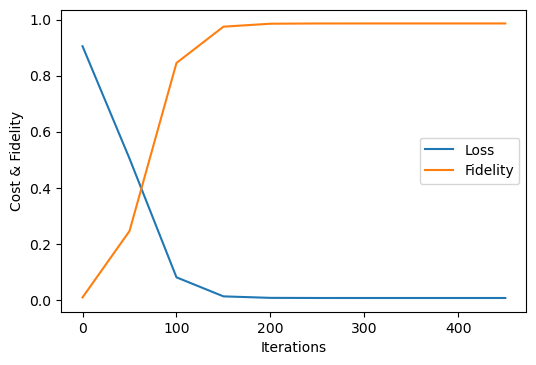

In [16]:
plt.plot(np.arange(0, 500, 50), loss_list, label="Loss")
plt.plot(np.arange(0, 500, 50), fidelity_list, label="Fidelity")
plt.xlabel('Iterations')
plt.ylabel('Cost & Fidelity')
plt.legend()
plt.show()

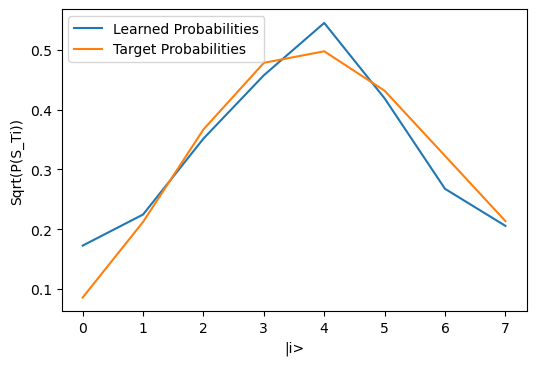

In [17]:
plt.plot(np.arange(0, 8), learned, label="Learned Probabilities")
plt.plot(np.arange(0, 8), amplitudes, label="Target Probabilities")
plt.xlabel('|i>')
plt.ylabel('Sqrt(P(S_Ti))')
plt.legend()
plt.show()

#### Question 3.1(c)

##### Two layers

In [18]:
num_layers = 2
var_init = 0.01 * np.random.randn(num_layers, 6)
loss_list, fidelity_list, learned = circuit_1(var_init, 1, amplitudes)

Iter:     1 | Loss: 0.8995071 | Fidelity: 0.0100988 
Iter:    51 | Loss: 0.1512274 | Fidelity: 0.7204149 
Iter:   101 | Loss: 0.0511751 | Fidelity: 0.9002686 
Iter:   151 | Loss: 0.0236110 | Fidelity: 0.9533354 
Iter:   201 | Loss: 0.0110248 | Fidelity: 0.9780719 
Iter:   251 | Loss: 0.0061013 | Fidelity: 0.9878347 
Iter:   301 | Loss: 0.0042888 | Fidelity: 0.9914407 
Iter:   351 | Loss: 0.0035794 | Fidelity: 0.9928539 
Iter:   401 | Loss: 0.0032668 | Fidelity: 0.9934771 
Iter:   451 | Loss: 0.0031125 | Fidelity: 0.9937848 
Final values:
Loss: 0.0030310 | Fidelity: 0.9939472 


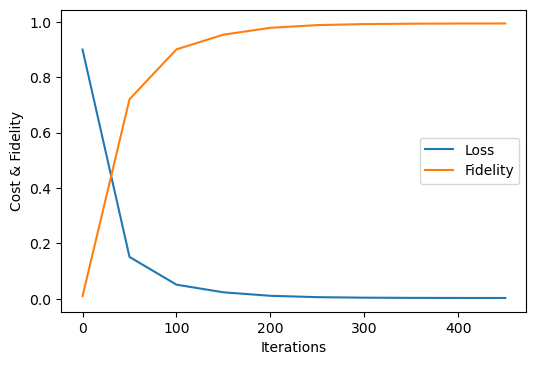

In [19]:
plt.plot(np.arange(0, 500, 50), loss_list, label="Loss")
plt.plot(np.arange(0, 500, 50), fidelity_list, label="Fidelity")
plt.xlabel('Iterations')
plt.ylabel('Cost & Fidelity')
plt.legend()
plt.show()

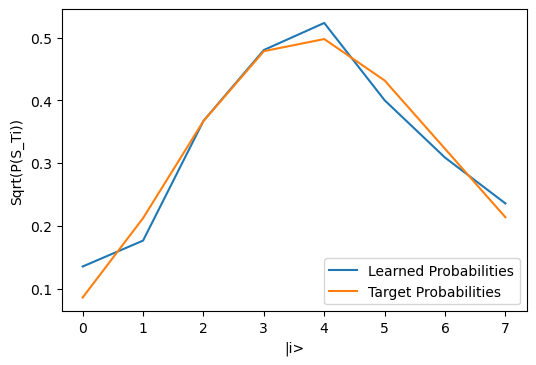

In [20]:
plt.plot(np.arange(0, 8), learned, label="Learned Probabilities")
plt.plot(np.arange(0, 8), amplitudes, label="Target Probabilities")
plt.xlabel('|i>')
plt.ylabel('Sqrt(P(S_Ti))')
plt.legend()
plt.show()

### Question 3.2

In [1]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.opflow import I, X, Z

#### Question 3.2(a)

In [2]:
distance_and_coeffs = np.array([
    [0.05,  1.00777E+01,	-1.05533E+00,	1.55708E-01,	-1.05533E+00,	1.39333E-02],
    [0.10,	4.75665E+00,	-1.02731E+00,	1.56170E-01,	-1.02731E+00,	1.38667E-02],
    [0.15,	2.94817E+00,	-9.84234E-01,	1.56930E-01,	-9.84234E-01,	1.37610E-02],
    [0.20,	2.01153E+00,	-9.30489E-01,	1.57973E-01,	-9.30489E-01,	1.36238E-02],
    [0.25,	1.42283E+00,	-8.70646E-01,	1.59277E-01,	-8.70646E-01,	1.34635E-02],
    [0.30,	1.01018E+00,	-8.08649E-01,	1.60818E-01,	-8.08649E-01,	1.32880E-02],
    [0.35,	7.01273E-01,	-7.47416E-01,	1.62573E-01,	-7.47416E-01,	1.31036E-02],
    [0.40,	4.60364E-01,	-6.88819E-01,	1.64515E-01,	-6.88819E-01,	1.29140E-02],
    [0.45,	2.67547E-01,	-6.33890E-01,	1.66621E-01,	-6.33890E-01,	1.27192E-02],
    [0.50,	1.10647E-01,	-5.83080E-01,	1.68870E-01,	-5.83080E-01,	1.25165E-02],
    [0.55,	-1.83734E-02,	-5.36489E-01,	1.71244E-01,	-5.36489E-01,	1.23003E-02],
    [0.65,	-2.13932E-01,	-4.55433E-01,	1.76318E-01,	-4.55433E-01,	1.18019E-02],
    [0.75,	-3.49833E-01,	-3.88748E-01,	1.81771E-01,	-3.88748E-01,	1.11772E-02],
    [0.85,	-4.45424E-01,	-3.33747E-01,	1.87562E-01,    -3.33747E-01,	1.04061E-02],
    [0.95,	-5.13548E-01,	-2.87796E-01,	1.93650E-01,	-2.87796E-01,	9.50345E-03],
    [1.05,	-5.62600E-01,	-2.48783E-01,	1.99984E-01,	-2.48783E-01,	8.50998E-03],
    [1.15,	-5.97973E-01,	-2.15234E-01,	2.06495E-01,	-2.15234E-01,	7.47722E-03],
    [1.25,	-6.23223E-01,	-1.86173E-01,	2.13102E-01,	-1.86173E-01,	6.45563E-03],
    [1.35,	-6.40837E-01,	-1.60926E-01,	2.19727E-01,	-1.60926E-01,	5.48623E-03],
    [1.45,	-6.52661E-01,	-1.38977E-01,	2.26294E-01,	-1.38977E-01,	4.59760E-03],
    [1.55,	-6.60117E-01,	-1.19894E-01,	2.32740E-01,	-1.19894E-01,	3.80558E-03],
    [1.65,	-6.64309E-01,	-1.03305E-01,	2.39014E-01,	-1.03305E-01,	3.11545E-03],
    [1.75,	-6.66092E-01,	-8.88906E-02,	2.45075E-01,	-8.88906E-02,	2.52480E-03],
    [1.85,	-6.66126E-01,	-7.63712E-02,	2.50896E-01,	-7.63712E-02,	2.02647E-03],
    [1.95,	-6.64916E-01,	-6.55065E-02,	2.56458E-01,	-6.55065E-02,	1.61100E-03],
    [2.05,	-6.62844E-01,	-5.60866E-02,	2.61750E-01,	-5.60866E-02,	1.26812E-03],
    [2.15,	-6.60199E-01,	-4.79275E-02,	2.66768E-01,	-4.79275E-02,	9.88000E-04],
    [2.25,	-6.57196E-01,	-4.08672E-02,	2.71512E-01,	-4.08672E-02,	7.61425E-04],
    [2.35,	-6.53992E-01,	-3.47636E-02,	2.75986E-01,	-3.47636E-02,	5.80225E-04],
    [2.45,	-6.50702E-01,	-2.94924E-02,	2.80199E-01,	-2.94924E-02,	4.36875E-04],
    [2.55,	-6.47408E-01,	-2.49459E-02,	2.84160E-01,	-2.49459E-02,	3.25025E-04],
    [2.65,	-6.44165E-01,	-2.10309E-02,	2.87881E-01,	-2.10309E-02,	2.38800E-04],
    [2.75,	-6.41011E-01,	-1.76672E-02,	2.91376E-01,	-1.76672E-02,	1.73300E-04],
    [2.85,	-6.37971E-01,	-1.47853E-02,	2.94658E-01,	-1.47853E-02,	1.24200E-04],
    [2.95,	-6.35058E-01,	-1.23246E-02,	2.97741E-01,	-1.23246E-02,	8.78750E-05],
    [3.05,	-6.32279E-01,	-1.02318E-02,	3.00638E-01,	-1.02317E-02,	6.14500E-05],
    [3.15,	-6.29635E-01,	-8.45958E-03,	3.03362E-01,	-8.45958E-03,	4.24250E-05],
    [3.25,	-6.27126E-01,	-6.96585E-03,	3.05927E-01,	-6.96585E-03,	2.89500E-05],
    [3.35,	-6.24746E-01,	-5.71280E-03,	3.08344E-01,	-5.71280E-03,	1.95500E-05],
    [3.45,	-6.22491E-01,	-4.66670E-03,	3.10625E-01,	-4.66670E-03,	1.30500E-05],
    [3.55,	-6.20353E-01,	-3.79743E-03,	3.12780E-01,	-3.79743E-03,	8.57500E-06],
    [3.65,	-6.18325E-01,	-3.07840E-03,	3.14819E-01,	-3.07840E-03,	5.60000E-06],
    [3.75,	-6.16401E-01,	-2.48625E-03,	3.16750E-01,	-2.48625E-03,	3.60000E-06],
    [3.85,	-6.14575E-01,	-2.00063E-03,	3.18581E-01,	-2.00062E-03,	2.27500E-06],
    [3.95,	-6.12839E-01,	-1.60393E-03,	3.20320E-01,	-1.60392E-03,	1.42500E-06]
])

In [3]:
def hamiltonianH2(coeff_I, coeff_Z1, coeff_X1X2, coeffZ_2, coeff_Z1Z2):
    return coeff_I*(I^I) + coeff_Z1*(I^Z) + coeffZ_2*(Z^I) + coeff_X1X2*(X^X) + coeff_Z1Z2*(Z^Z)

In [13]:
def Ground_state_energy(bond_length):
    index_of_coef = list(distance_and_coeffs.T[0]).index(bond_length)
    # define the Hamiltonian
    H2_op = (distance_and_coeffs[index_of_coef][1] * I ^ I) + \
            (distance_and_coeffs[index_of_coef][2] * I ^ Z) + \
            (distance_and_coeffs[index_of_coef][3] * Z ^ I) + \
            (distance_and_coeffs[index_of_coef][4] * Z ^ Z) + \
            (distance_and_coeffs[index_of_coef][5] * X ^ X)

    print(f'Number of qubits: {H2_op.num_qubits}')
    
    npme = NumPyMinimumEigensolver()
    result = npme.compute_minimum_eigenvalue(operator=H2_op)
    ref_value = result.eigenvalue.real
    print(f'Reference value: {ref_value:.5f}')
    
    seed = 170
    iterations = 125
    algorithm_globals.random_seed = seed
    backend = Aer.get_backend('aer_simulator')
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    # create the parameter
    theta = Parameter('theta')
    
    ansatz = QuantumCircuit(2, name="ansatz")
    ansatz.cx(0, 1)
    ansatz.ry(theta, 0)
    ansatz.cx(0, 1)
    
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'Ground state energy when the bond length is {bond_length}A: {result.eigenvalue.real:.5f}')
    # print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

    return ansatz, result.eigenvalue.real

Number of qubits: 2
Reference value: -0.94586
Ground state energy when the bond length is 0.75A: -0.94606


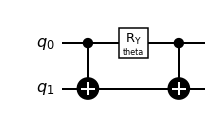

In [14]:
ansatz, ground_state_energy = Ground_state_energy(0.75)
ansatz.draw('mpl', style='bw')

#### Question 3.2(b)

In [15]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

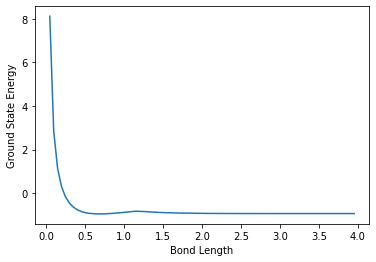

In [16]:
bond_lengths = list(distance_and_coeffs.T[0])
ground_state_energy_list = []
for bond_length in bond_lengths:
    with HiddenPrints():
        _, ground_state_energy = Ground_state_energy(bond_length)
    ground_state_energy_list.append(ground_state_energy)

plt.plot(bond_lengths, ground_state_energy_list)
plt.xlabel('Bond Length')
plt.ylabel('Ground State Energy')
plt.show()

In [20]:
min_bond_length = bond_lengths[ground_state_energy_list.index(min(ground_state_energy_list))]
print("The bond length that gives the minimal energy is: ", min_bond_length)

The bond length that gives the minimal energy is:  0.65


### Question 3.3

#### Question 3.3(a)

\begin{equation}
    A \vec{x} = \vec{b} \\
    A = \begin{bmatrix}
                1.2 & -0.3 \\
                -0.3 & 0.8
            \end{bmatrix}
    \quad\quad 
    \vec{x} = \begin{bmatrix}
                x \\
                y
            \end{bmatrix}
    \quad\quad 
    \vec{b} = \begin{bmatrix}
                1 \\
                1
            \end{bmatrix}
\end{equation}

To solve the equation:

\begin{align}
    \vec{x} &= A^{-1} \vec{b} \\
            &= \frac{1}{1.2\times0.8-(-0.3\times-0.3)}
            \begin{bmatrix}
                0.8 & 0.3 \\
                0.3 & 1.2
            \end{bmatrix}
            \begin{bmatrix}
                1 \\
                1
            \end{bmatrix} \\
            &\approx \begin{bmatrix}
                1.264 \\
                1.724
            \end{bmatrix} \\
\end{align}

Calculation as below:

In [22]:
I = np.identity(2)
A = np.matrix([[1.2,-0.3], [-0.3,0.8]])
b = np.array([1,1])
x = np.array(np.linalg.inv(A)@b)
print("Classical solution:\n", x)

norm_x = x / np.sqrt(np.sum(x**2))
print("Normalized classical solution:\n", norm_x)

b = b / np.linalg.norm(b)

Classical solution:
 [[1.26436782 1.72413793]]
Normalized classical solution:
 [[0.59136366 0.806405  ]]


Thus, the normalized solution 
$\hat{x} \approx \begin{bmatrix}
                0.591 \\
                0.806
            \end{bmatrix}$

With constructing a Hamiltonian:

\begin{align}
    H &= A^{\dagger}(I - |b\rangle \langle b|)A
\end{align}

where $|b\rangle$ is the normalized version of $\vec{b}$.

Since A is Hermitian,

\begin{equation}
    A^{\dagger} = A = \begin{bmatrix}
                1.2 & -0.3 \\
                -0.3 & 0.8
        \end{bmatrix}
\end{equation}

Then, 

\begin{align}
    H &=    \begin{bmatrix}
                1.2 & -0.3 \\
                -0.3 & 0.8
            \end{bmatrix}
            (\begin{bmatrix}
                1 & 0 \\
                0 & 1
            \end{bmatrix} - 
            \frac{1}{\sqrt(2)}
            \begin{bmatrix}
                1 \\
                1
            \end{bmatrix} \otimes
            \frac{1}{\sqrt(2)}
            \begin{bmatrix}
                1 \quad 1
            \end{bmatrix})
            \begin{bmatrix}
                1.2 & -0.3 \\
                -0.3 & 0.8
            \end{bmatrix} \\
      &=    \frac{1}{2}
            \begin{bmatrix}
                1.2 & -0.3 \\
                -0.3 & 0.8
            \end{bmatrix}
            \begin{bmatrix}
                1 & -1 \\
                -1 & 1
            \end{bmatrix}
            \begin{bmatrix}
                1.2 & -0.3 \\
                -0.3 & 0.8
            \end{bmatrix} \\
      &=    \begin{bmatrix}
                1.125 & -0.825 \\
                -0.825 & 0.605
            \end{bmatrix}
\end{align}

Calculation as below:

In [23]:
H = 1/2*A.H@[[1,-1],[-1,1]]@A
print("Hamilitonian:\n", H)

Hamilitonian:
 [[ 1.125 -0.825]
 [-0.825  0.605]]


#### Question 3.3(b)

In [32]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from numpy import pi
from matplotlib import pylab as pl
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sv_simulator = Aer.get_backend('statevector_simulator')
simulator = Aer.get_backend('aer_simulator_statevector')

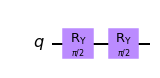

In [33]:
def trial_circuit(theta0, theta1):
    # Initialize the quantum and classical registers
    qr = QuantumRegister(1)
    qc = QuantumCircuit(1)
    
    qc.ry(theta0, 0)
    qc.ry(theta1, 0)
    
    return qc

trial_circuit(*(0.5*np.pi, 0.5*np.pi)).draw('mpl')

In [34]:
def cost_function(theta):
    
    qc = trial_circuit(theta[0], theta[1])
    qc.save_statevector()
    
    # Now run on a simulator
    # Run and get statevector
    psi = simulator.run(qc).result().get_statevector(qc)
    psi = psi.data
    return (psi @ H @ psi).item()

def cost_function_plot(theta0, theta1):
    qc = trial_circuit(theta0, theta1)
    qc.save_statevector()
    
    # Now run on a simulator
    # Run and get statevector
    psi = simulator.run(qc).result().get_statevector(qc)
    psi = psi.data
    return (psi @ H @ psi).item()

# Let's plot the cost function
theta0 = np.arange(0, 2*np.pi, 0.05)
theta1 = np.arange(0, 2*np.pi, 0.05)
theta0p, theta1p = np.meshgrid(theta0, theta1)
cost = np.zeros(theta0p.shape)
for i in range(theta0p.shape[0]):
    for j in range(theta0p.shape[1]):
        theta0_ = theta0p[i,j]
        theta1_ = theta1p[i,j]
        cost[i,j] = np.real(cost_function_plot(theta0_, theta1_))

# pl.contourf(theta0p, theta1p, cost, 40, cmap='RdGy')
# pl.xlabel("$theta_0$")
# pl.ylabel("$theta_1$")
# pl.colorbar()
# pl.show()

In [35]:
from scipy.optimize import minimize
res = minimize(cost_function, x0 = (0., 0.), method="COBYLA", bounds=[(0, np.pi*2),(0, np.pi*2)])
print(res)

     fun: 1.539191247334592e-08
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 34
  status: 1
 success: True
       x: array([0.97913544, 0.89677089])


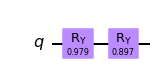

In [36]:
theta_opt_ = res.x
circuit= trial_circuit(*theta_opt_)

circuit.draw('mpl')

In [37]:
job = sv_simulator.run(circuit)
results = job.result()
results = results.get_statevector().real
results

array([0.59143972, 0.80634921])

In [61]:
eigenvalues_H, eigenvectors_H = eig(H)
ground_state = eigenvectors_H[list(eigenvalues_H).index(min(eigenvalues_H))]
print("ground_state:\n", ground_state)

ground_state:
 [[-0.59136366  0.806405  ]]


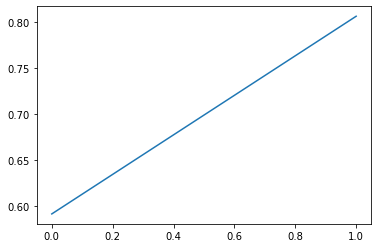

In [62]:
pl.plot(results)

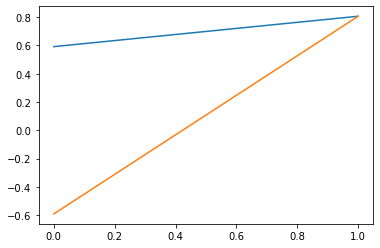

In [63]:
pl.plot(results)
pl.plot(np.array(ground_state)[0])

I tried...